In [1]:
import sklearn as skl
import pickle as pkl
import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.svm
import sklearn.metrics

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import seaborn as sns

from itertools import chain

In [2]:
import scipy as sp

In [3]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

In [4]:
import sys
sys.path.append("..") # or wherever the package is
import kuanglu

In [5]:
import scanpy as sc

In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

## Exp 1: simple FF for embedding

In [7]:
adata = sc.read_h5ad('data/demo1_sp_adata.h5ad')

train_Xs = []
chosen_slices = ['MsBrainAgingSpatialDonor_5_0', 'MsBrainAgingSpatialDonor_6_0', 
                 'MsBrainAgingSpatialDonor_7_0']
for i in chosen_slices:
    train_Xs.append(np.array(adata.X[adata.obs['donor_slice'] == i, :]))
    
validate_Xs = []
chosen_donors = ['MsBrainAgingSpatialDonor_8_0']
for i in chosen_donors:
    validate_Xs.append(np.array(adata.X[adata.obs['donor_slice'] == i, :]))
    
_, p = train_Xs[0].shape

class MyDataSet(Data.Dataset):
    def __init__(self, Xs):
        super(MyDataSet, self).__init__()
        self.Xs = [torch.Tensor(X) for X in Xs]
        
    def __len__(self):
        return len(self.Xs)

    def __getitem__(self, idx):
        return self.Xs[idx]

train_data = MyDataSet(train_Xs)
train_loader = Data.DataLoader(train_data, batch_size=1, shuffle=True) 

print("Training data dimensions:")
for i in train_Xs:
    print(i.shape)

validate_data = MyDataSet(validate_Xs)
validate_loader = Data.DataLoader(validate_data, batch_size=1, shuffle=True)

print("Validation data dimensions:")
for i in validate_Xs:
    print(i.shape)

Training data dimensions:
(5000, 374)
(5000, 374)
(5000, 374)
Validation data dimensions:
(5000, 374)


In [8]:
embed_config = {
    'embedType': 'ff',
    'ldim': [p, 512, 256, 128],
}

model = kuanglu.Model(d_gene=p, 
                      d_denoise = [p], 
                      d_quality=[512, 256, 1], 
                      lbd=1.,
                      embed_config=embed_config,
                      ).to('cuda')

In [9]:
rec = model.fit('denoised', train_loader, validate_loader, [0, 500],
                fix=['embed', 'qualify', 'smooth', 'interact'], lr=1e-4)

/home/caoyufan/kuanglu/examples/../kuanglu/model.py:312: UserWarning: Parameter containing:
tensor(100., device='cuda:0') is already fixed. They will be unfixed when exiting this function.
  warnings.warn(f"{param} is already fixed. They will be unfixed when exiting this function.")


Epoch 0001 Train MSE 0.963 Validate MSE 1.044 Raw MSE 1.022
Epoch 0002 Train MSE 0.964 Validate MSE 1.032 Raw MSE 1.012
Epoch 0003 Train MSE 0.956 Validate MSE 0.996 Raw MSE 0.976
Epoch 0004 Train MSE 0.977 Validate MSE 1.035 Raw MSE 1.014
Epoch 0005 Train MSE 0.967 Validate MSE 1.015 Raw MSE 0.990
Epoch 0006 Train MSE 0.968 Validate MSE 1.033 Raw MSE 1.008
Epoch 0007 Train MSE 0.957 Validate MSE 1.034 Raw MSE 1.016
Epoch 0008 Train MSE 0.960 Validate MSE 1.038 Raw MSE 1.018
Epoch 0009 Train MSE 0.966 Validate MSE 1.039 Raw MSE 1.019
Epoch 0010 Train MSE 0.953 Validate MSE 1.045 Raw MSE 1.021
Epoch 0011 Train MSE 0.960 Validate MSE 1.033 Raw MSE 1.012
Epoch 0012 Train MSE 0.957 Validate MSE 1.036 Raw MSE 1.017
Epoch 0013 Train MSE 0.971 Validate MSE 1.041 Raw MSE 1.021
Epoch 0014 Train MSE 0.953 Validate MSE 1.015 Raw MSE 0.991
Epoch 0015 Train MSE 0.957 Validate MSE 1.048 Raw MSE 1.028
Epoch 0016 Train MSE 0.949 Validate MSE 1.016 Raw MSE 0.994
Epoch 0017 Train MSE 0.937 Validate MSE 

In [10]:
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [500, 750],
                                           fix=['denoise', 'interact'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [750, 1000],
                                           fix=['interact'], lr=1e-4))

Epoch 0501 Train MSE 0.945 Validate MSE 0.974 Raw MSE 0.989
Epoch 0502 Train MSE 0.921 Validate MSE 0.997 Raw MSE 1.024
Epoch 0503 Train MSE 0.906 Validate MSE 0.972 Raw MSE 0.996
Epoch 0504 Train MSE 0.910 Validate MSE 0.969 Raw MSE 1.013
Epoch 0505 Train MSE 0.896 Validate MSE 0.957 Raw MSE 1.002


Epoch 0506 Train MSE 0.904 Validate MSE 0.952 Raw MSE 0.994
Epoch 0507 Train MSE 0.885 Validate MSE 0.962 Raw MSE 1.021
Epoch 0508 Train MSE 0.899 Validate MSE 0.962 Raw MSE 1.011
Epoch 0509 Train MSE 0.885 Validate MSE 0.951 Raw MSE 1.012
Epoch 0510 Train MSE 0.879 Validate MSE 0.955 Raw MSE 1.021
Epoch 0511 Train MSE 0.859 Validate MSE 0.941 Raw MSE 1.005
Epoch 0512 Train MSE 0.876 Validate MSE 0.956 Raw MSE 1.031
Epoch 0513 Train MSE 0.893 Validate MSE 0.977 Raw MSE 1.046
Epoch 0514 Train MSE 0.895 Validate MSE 0.926 Raw MSE 0.995
Epoch 0515 Train MSE 0.877 Validate MSE 0.953 Raw MSE 1.024
Epoch 0516 Train MSE 0.868 Validate MSE 0.946 Raw MSE 1.014
Epoch 0517 Train MSE 0.856 Validate MSE 0.944 Raw MSE 1.028
Epoch 0518 Train MSE 0.857 Validate MSE 0.908 Raw MSE 0.995
Epoch 0519 Train MSE 0.874 Validate MSE 0.915 Raw MSE 0.995
Epoch 0520 Train MSE 0.854 Validate MSE 0.917 Raw MSE 0.995
Epoch 0521 Train MSE 0.860 Validate MSE 0.944 Raw MSE 1.035
Epoch 0522 Train MSE 0.859 Validate MSE 

In [11]:
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [1000, 1250],
                                           fix=['denoise', 'embed', 'qualify', 'smooth'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [1250, 1500], lr=1e-4))

Epoch 1001 Train MSE 0.833 Validate MSE 0.886 Raw MSE 1.009
Epoch 1002 Train MSE 0.853 Validate MSE 0.862 Raw MSE 0.985
Epoch 1003 Train MSE 0.834 Validate MSE 0.903 Raw MSE 1.007
Epoch 1004 Train MSE 0.832 Validate MSE 0.918 Raw MSE 1.038
Epoch 1005 Train MSE 0.833 Validate MSE 0.920 Raw MSE 1.046
Epoch 1006 Train MSE 0.833 Validate MSE 0.886 Raw MSE 1.013


Epoch 1007 Train MSE 0.830 Validate MSE 0.910 Raw MSE 1.023
Epoch 1008 Train MSE 0.831 Validate MSE 0.905 Raw MSE 1.016
Epoch 1009 Train MSE 0.829 Validate MSE 0.902 Raw MSE 1.017
Epoch 1010 Train MSE 0.825 Validate MSE 0.887 Raw MSE 0.999
Epoch 1011 Train MSE 0.842 Validate MSE 0.907 Raw MSE 1.030
Epoch 1012 Train MSE 0.838 Validate MSE 0.892 Raw MSE 1.000
Epoch 1013 Train MSE 0.819 Validate MSE 0.908 Raw MSE 1.008
Epoch 1014 Train MSE 0.822 Validate MSE 0.902 Raw MSE 1.010
Epoch 1015 Train MSE 0.829 Validate MSE 0.894 Raw MSE 1.019
Epoch 1016 Train MSE 0.842 Validate MSE 0.864 Raw MSE 0.987
Epoch 1017 Train MSE 0.830 Validate MSE 0.889 Raw MSE 1.017
Epoch 1018 Train MSE 0.827 Validate MSE 0.885 Raw MSE 0.999
Epoch 1019 Train MSE 0.830 Validate MSE 0.919 Raw MSE 1.035
Epoch 1020 Train MSE 0.830 Validate MSE 0.928 Raw MSE 1.030
Epoch 1021 Train MSE 0.824 Validate MSE 0.878 Raw MSE 1.010
Epoch 1022 Train MSE 0.830 Validate MSE 0.895 Raw MSE 1.008
Epoch 1023 Train MSE 0.825 Validate MSE 

Text(0, 0.5, 'MSE')

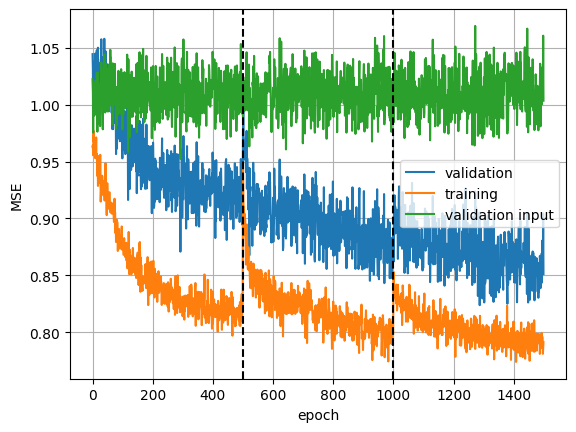

In [12]:
plt.plot(rec['validate_epoch'], rec['validate_mse'], label='validation')
plt.plot(rec['train_epoch'], rec['train_mse'], label='training')
plt.plot(rec['validate_epoch'], rec['raw_mse'], label='validation input')
plt.legend()
plt.grid()
plt.axvline(500, ls='--', c='k')
plt.axvline(1000, ls='--', c='k')
plt.xlabel('epoch')
plt.ylabel('MSE')

In [13]:
mse_df = pd.DataFrame({'epoch': rec['validate_epoch'], 'mse': rec['validate_mse']})

def epoch2stage(x):
    if x < 250: return 'pre-denoise'
    elif x < 500: return 'denoise'
    elif x < 750: return 'pre-denoise-smooth'
    elif x < 1000: return 'denoise-smooth'
    elif x < 1250: return 'pre-denoise-smooth-enhance'
    elif x < 1500: return 'denoise-smooth-enhance'
    else: raise NotImplementedError('x >= 1500 not allowed')

mse_df['stage'] = mse_df['epoch'].apply(epoch2stage)
mse_df

epoch       mse                   stage
0         0  1.044437             pre-denoise
1         1  1.031632             pre-denoise
2         2  0.995659             pre-denoise
3         3  1.034661             pre-denoise
4         4  1.014707             pre-denoise
...     ...       ...                     ...
1495   1495  0.880518  denoise-smooth-enhance
1496   1496  0.863904  denoise-smooth-enhance
1497   1497  0.860152  denoise-smooth-enhance
1498   1498  0.904287  denoise-smooth-enhance
1499   1499  0.850987  denoise-smooth-enhance

[1500 rows x 3 columns]

/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


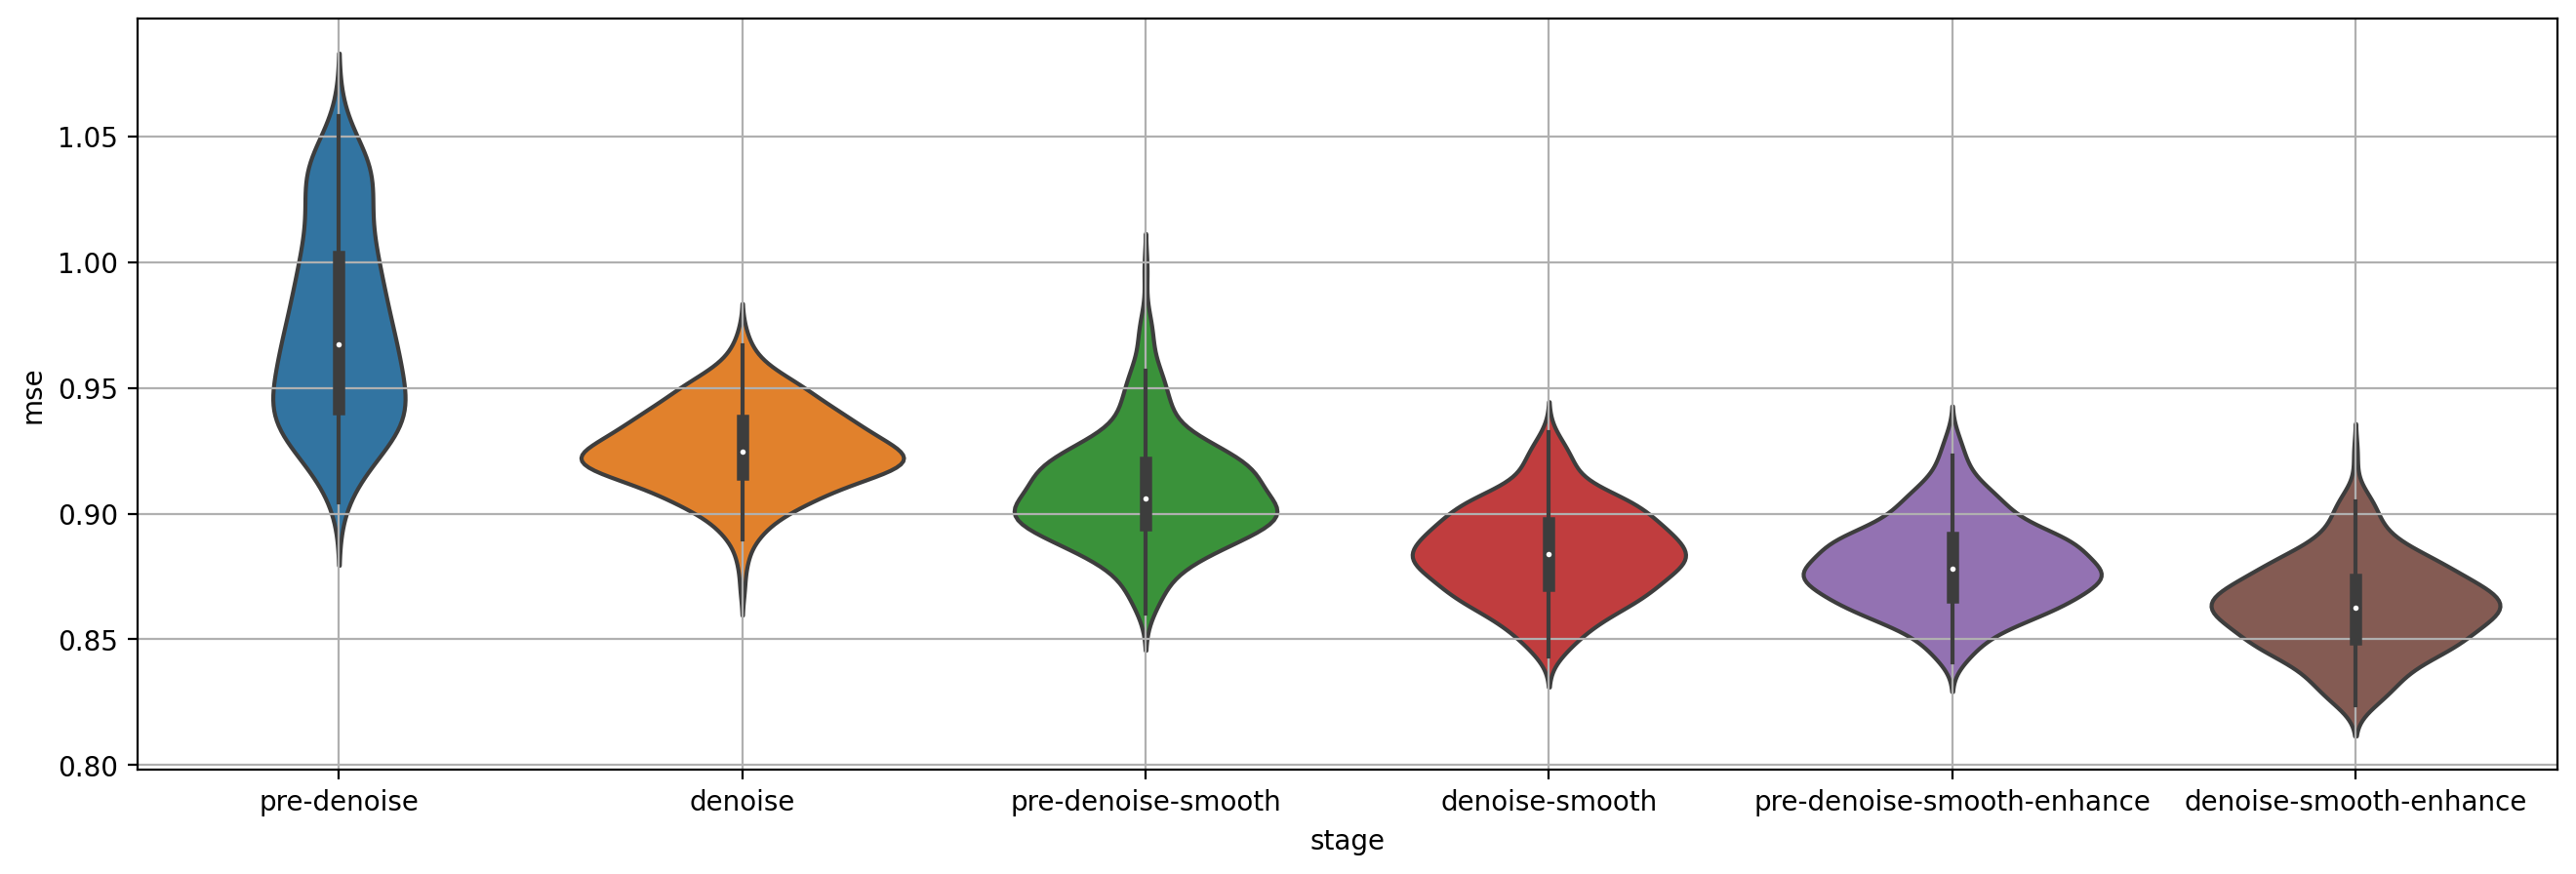

In [14]:
# sns.violinplot(mse_df[~mse_df['stage'].str.contains('pre-')], x='stage', y='mse')
%config InlineBackend.figure_format ='retina'
plt.figure(figsize=(16, 5))
sns.violinplot(mse_df, x='stage', y='mse')
plt.grid()

In [15]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'])

print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise') / sum(mse_df['stage'] == 'denoise-smooth'))

p = 4.634988558040362e-68 f = 0.950576


In [16]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth-enhance', 'mse'])
print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise-smooth') / sum(mse_df['stage'] == 'denoise-smooth-enhance'))

p = 7.481700800616457e-31 f = 0.798496


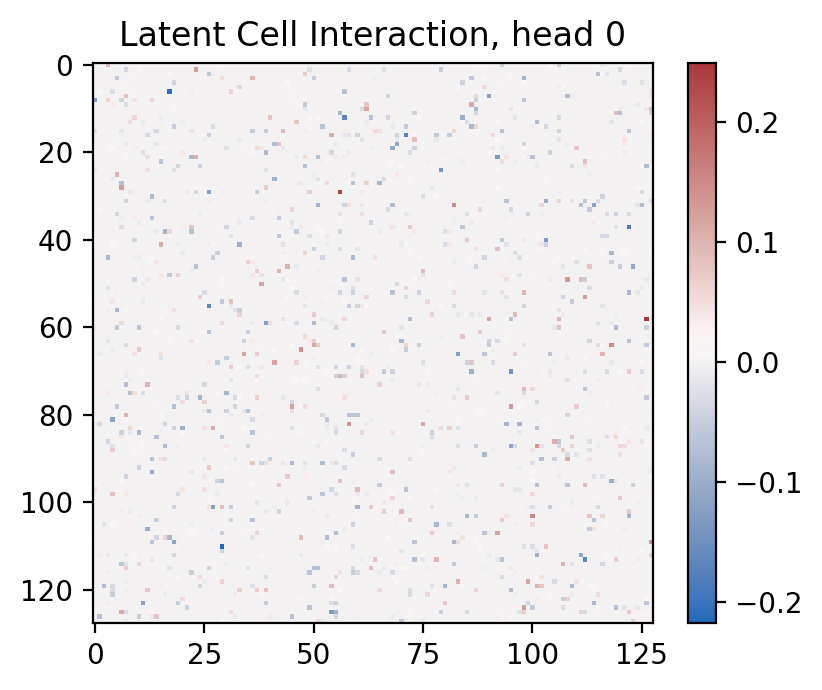

In [17]:
# Plot heatmap of the parameters in cell interaction module

weight_CIs = []
for head in range(len(model.cell_interacts)):
    weight_CIs.append(model.cell_interacts[head].transform.data)

plt.figure(figsize=(10, 8))
for i, weight_CI in enumerate(weight_CIs):
    weight_array = weight_CI.cpu().numpy()
    plt.subplot(2, 2, i + 1)
    plt.imshow(weight_array, cmap='vlag')
    plt.colorbar()
    plt.title(f'Latent Cell Interaction, head {i}')
plt.show()

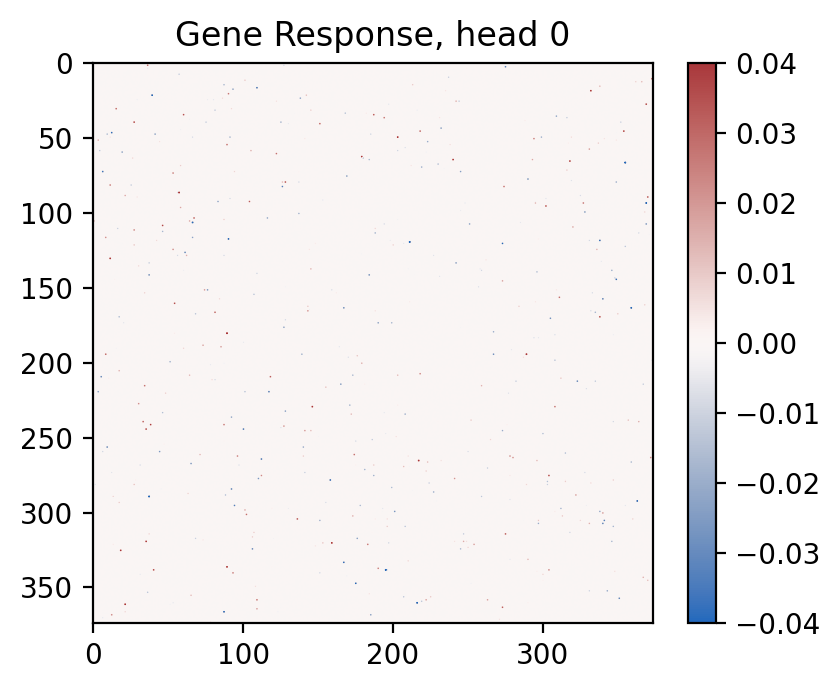

In [18]:
# Plot heatmap of the parameters in gene response module

weight_GRs = []
for head in range(len(model.cell_interacts)):
    weight_GRs.append(model.cell_interacts[head].gene_response.data)

plt.figure(figsize=(10, 8))
for i, weight_GR in enumerate(weight_GRs):
    weight_array = weight_GR.cpu().numpy()
    plt.subplot(2, 2, i + 1)
    plt.imshow(weight_array, cmap='vlag', vmin=-.04, vmax=.04)
    plt.colorbar()
    plt.title(f'Gene Response, head {i}')
plt.show()

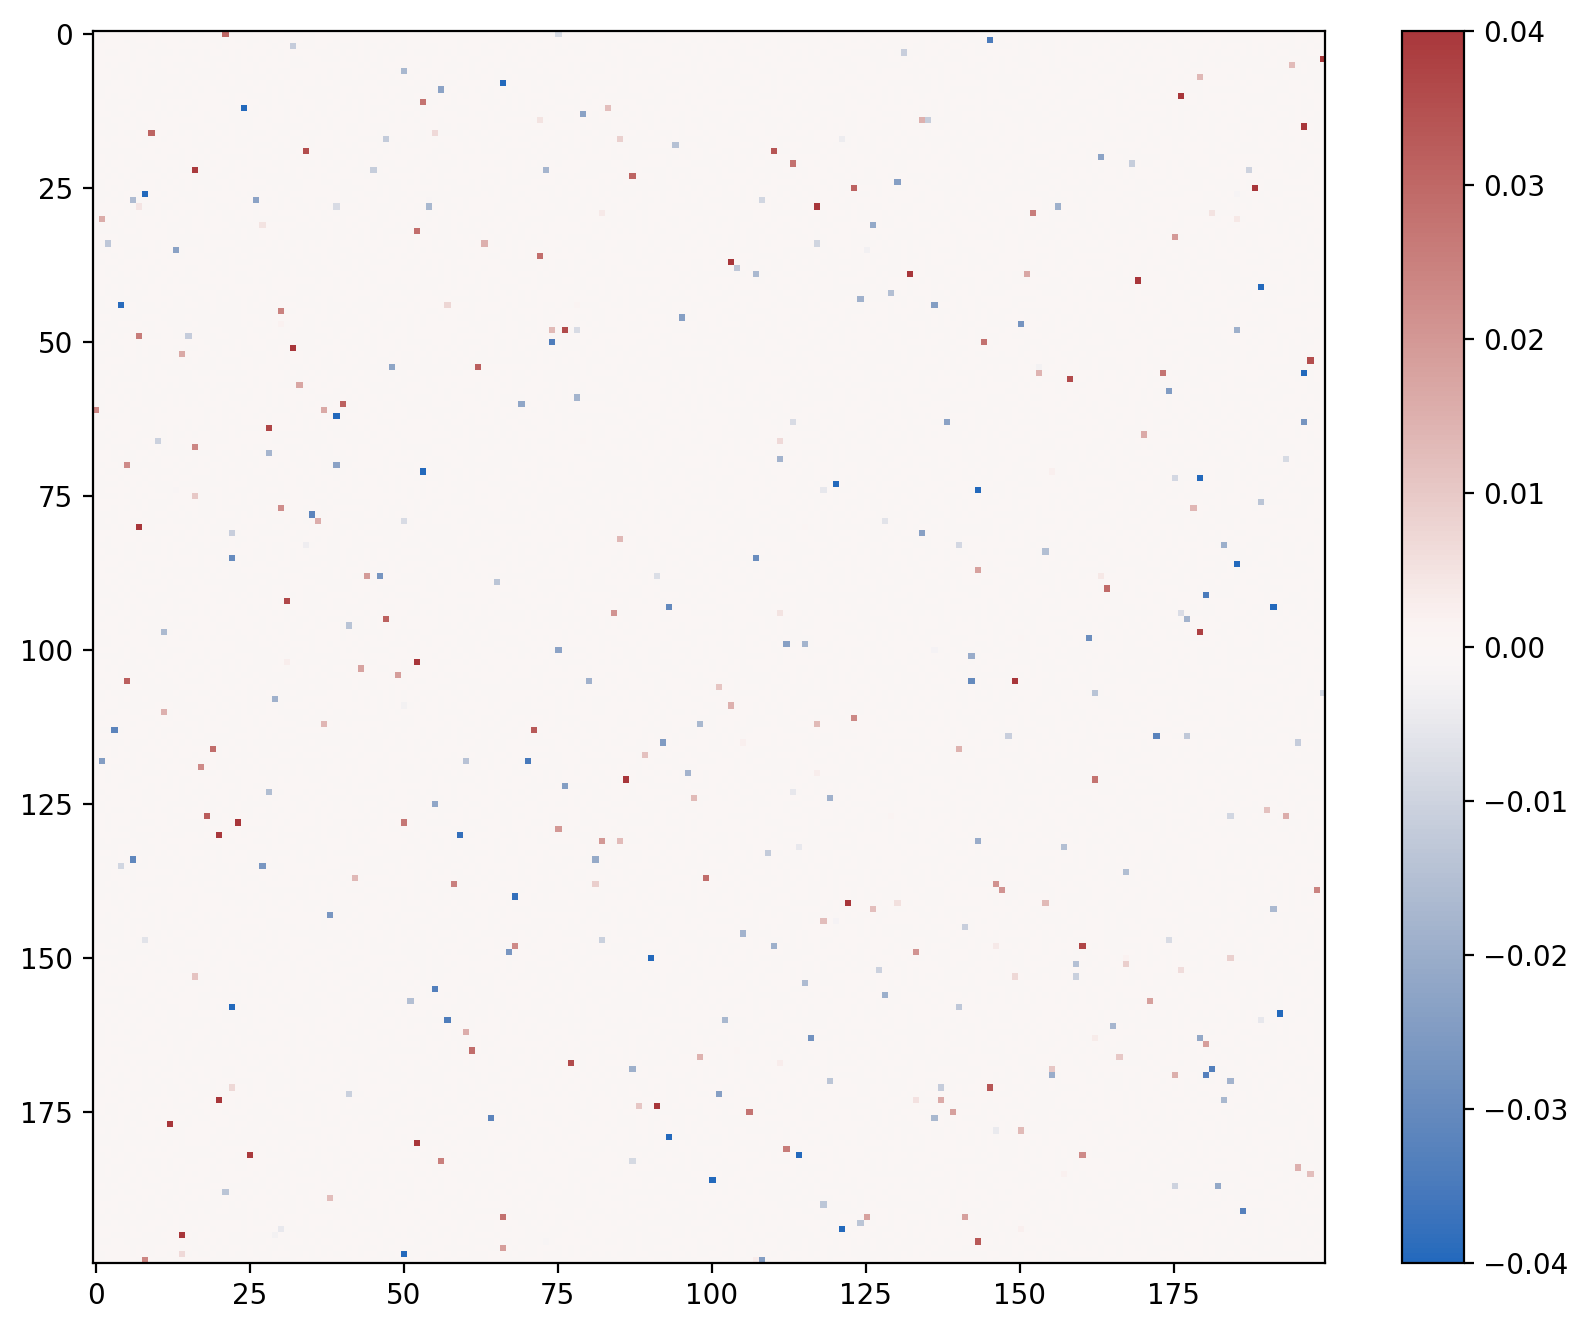

In [19]:
# Extract meaningful weights from Gene Response
THRESHOLD = 0.01

matGR = model.cell_interacts[0].gene_response.data.cpu().numpy()
col_max = np.max(np.abs(matGR), axis=0)
row_max = np.max(np.abs(matGR), axis=1)

meaningfulCols = np.where(col_max > THRESHOLD)[0]
meaningfulRows = np.where(row_max > THRESHOLD)[0]

meaningfulMatGR = matGR[meaningfulRows, :][:, meaningfulCols]

# meaningfulMatGR = np.clip(meaningfulMatGR, -.04, .04)

plt.figure(figsize=(10, 8))
plt.imshow(meaningfulMatGR, cmap='vlag', vmin=-.04, vmax=.04)
plt.colorbar()

In [20]:
# Find the indices of highest absolute values in the meaningfulMatGR

topK = 10
topK_indices = np.argsort(np.abs(matGR), axis=None)[-topK:]

topK_indices = np.unravel_index(topK_indices, matGR.shape)

topK_indices

(array([163,  86,  93, 360, 106, 180, 289, 338, 119,  66]),
 array([359,  57, 369, 216,  66,  89,  37, 195, 211, 355]))

In [21]:
np.abs(matGR)[topK_indices]

array([0.0596471 , 0.06105969, 0.06141175, 0.06247685, 0.06374813,
       0.06982911, 0.07328958, 0.07941381, 0.07946657, 0.09197832],
      dtype=float32)

In [22]:
# check the corresponding genes

LR_pairs = []

for i in range(topK):
    LR_pairs.append((adata.var.index[topK_indices[1][i]], 
                     adata.var.index[topK_indices[0][i]]))

LR_pairs

[('ENSMUSG00000053007', 'ENSMUSG00000005716'),
 ('ENSMUSG00000052336', 'ENSMUSG00000020734'),
 ('ENSMUSG00000044647', 'ENSMUSG00000074896'),
 ('ENSMUSG00000021090', 'ENSMUSG00000028370'),
 ('ENSMUSG00000034164', 'ENSMUSG00000039217'),
 ('ENSMUSG00000021665', 'ENSMUSG00000036814'),
 ('ENSMUSG00000022041', 'ENSMUSG00000038679'),
 ('ENSMUSG00000039239', 'ENSMUSG00000038718'),
 ('ENSMUSG00000047910', 'ENSMUSG00000025498'),
 ('ENSMUSG00000026083', 'ENSMUSG00000034164')]

In [23]:
import pandas as pd

lr_pairs = pd.read_csv('./mouse_lr_pair.csv')

lgID = lr_pairs['ligand_ensembl_gene_id']
rpID = lr_pairs['receptor_ensembl_gene_id']

lrID = pd.concat([lgID, rpID], axis=1)
# lrID

geneIDBank = set(adata.var.index)

# filter out the genes that are not in the dataset

lrID = lrID[lrID['ligand_ensembl_gene_id'].isin(geneIDBank) &
            lrID['receptor_ensembl_gene_id'].isin(geneIDBank)]
lrID

ligand_ensembl_gene_id receptor_ensembl_gene_id
26       ENSMUSG00000035385       ENSMUSG00000049103
50       ENSMUSG00000000869       ENSMUSG00000026770
52       ENSMUSG00000000869       ENSMUSG00000031304
275      ENSMUSG00000017344       ENSMUSG00000026768
323      ENSMUSG00000019772       ENSMUSG00000022206
334      ENSMUSG00000019997       ENSMUSG00000020122
339      ENSMUSG00000019997       ENSMUSG00000030786
467      ENSMUSG00000024164       ENSMUSG00000026616
469      ENSMUSG00000024164       ENSMUSG00000030724
470      ENSMUSG00000024164       ENSMUSG00000030786
1144     ENSMUSG00000024164       ENSMUSG00000000290
1153     ENSMUSG00000051439       ENSMUSG00000000290
1212     ENSMUSG00000049796       ENSMUSG00000003476
1296     ENSMUSG00000019772       ENSMUSG00000011171
1356     ENSMUSG00000025746       ENSMUSG00000020122
1357     ENSMUSG00000028364       ENSMUSG00000020122
1473     ENSMUSG00000002985       ENSMUSG00000023992
1557     ENSMUSG00000028364       ENSMUSG00000026768
1653     ENSMUSG00000002985       ENSMUSG00000015243
1900     ENSMUSG00000066551       ENSMUSG00000030786

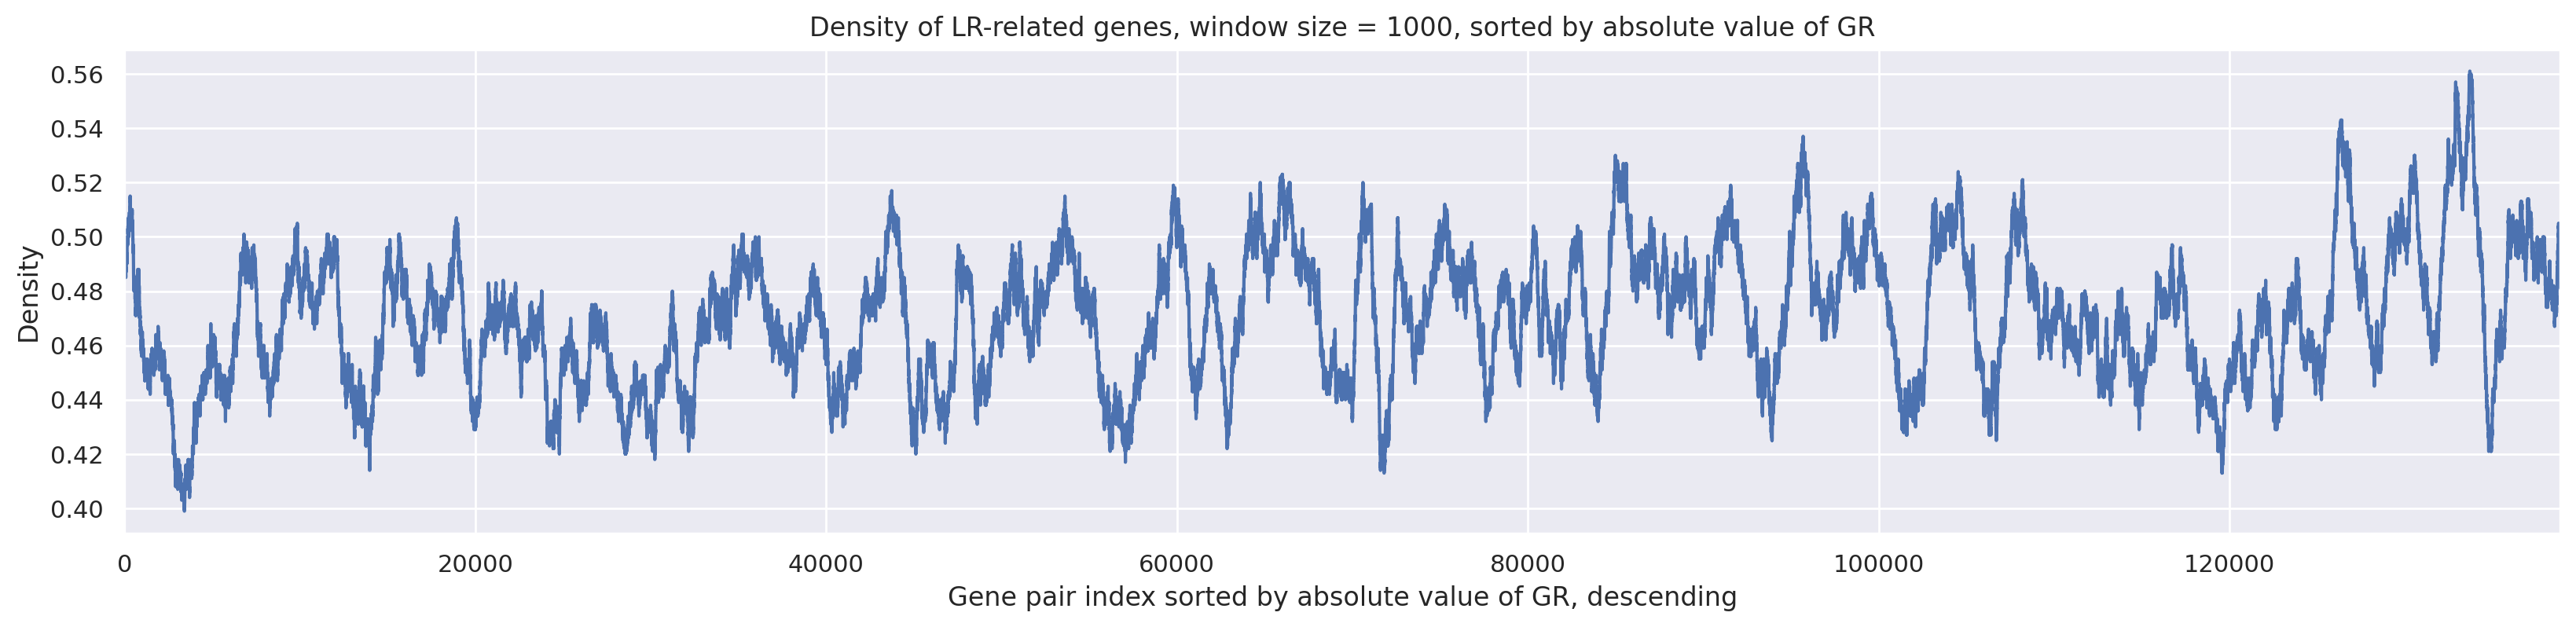

In [24]:
ranked_indices = np.argsort(np.abs(matGR), axis=None)
ranked_indices = np.unravel_index(ranked_indices, matGR.shape)

LR_related_genes = set(lgID) | set(rpID)

hasRelatedGenes = []

for indices in zip(ranked_indices[0], ranked_indices[1]):
    cnt = 0
    if adata.var.index[indices[0]] in LR_related_genes:
        cnt += 1
    if adata.var.index[indices[1]] in LR_related_genes:
        cnt += 1
    hasRelatedGenes.append(cnt)

hasRelatedGenes = np.array(hasRelatedGenes)

WINDOW_SIZE = 1000

density = []

for i in range(len(hasRelatedGenes) - WINDOW_SIZE):
    density.append(np.mean(hasRelatedGenes[i:i + WINDOW_SIZE]))
    
%config InlineBackend.figure_format ='retina'
sns.set()
plt.figure(figsize=(20, 4));
plt.plot(density);
plt.title(f'Density of LR-related genes, window size = {WINDOW_SIZE}, sorted by absolute value of GR');
plt.xlim(0, len(hasRelatedGenes) - WINDOW_SIZE);
plt.xlabel('Gene pair index sorted by absolute value of GR, descending');
plt.ylabel('Density');

In [25]:
genesCol = adata.var_names[meaningfulCols]
genesRow = adata.var_names[meaningfulRows]

genesCol, genesRow

(Index(['ENSMUSG00000018381', 'ENSMUSG00000024397', 'ENSMUSG00000017390',
        'ENSMUSG00000036777', 'ENSMUSG00000038115', 'ENSMUSG00000024411',
        'ENSMUSG00000060802', 'ENSMUSG00000031375', 'ENSMUSG00000021835',
        'ENSMUSG00000036896',
        ...
        'ENSMUSG00000055415', 'ENSMUSG00000053007', 'ENSMUSG00000045875',
        'ENSMUSG00000055761', 'ENSMUSG00000020160', 'ENSMUSG00000038872',
        'ENSMUSG00000044647', 'ENSMUSG00000097648', 'ENSMUSG00000024501',
        'ENSMUSG00000025754'],
       dtype='object', length=200),
 Index(['ENSMUSG00000035783', 'ENSMUSG00000020178', 'ENSMUSG00000037010',
        'ENSMUSG00000060802', 'ENSMUSG00000048251', 'ENSMUSG00000021835',
        'ENSMUSG00000036887', 'ENSMUSG00000036896', 'ENSMUSG00000045532',
        'ENSMUSG00000024164',
        ...
        'ENSMUSG00000023868', 'ENSMUSG00000055415', 'ENSMUSG00000041959',
        'ENSMUSG00000053007', 'ENSMUSG00000028370', 'ENSMUSG00000031839',
        'ENSMUSG00000045875', 'ENSM

In [26]:
meaningfulMatGR.shape

(200, 200)

([<matplotlib.axis.YTick at 0x7fcfdd7b1990>,
 [Text(0, 0, 'ENSMUSG00000021919'),
  Text(0, 1, 'ENSMUSG00000028150'),
  Text(0, 2, 'ENSMUSG00000034855'),
  Text(0, 3, 'ENSMUSG00000031997'),
  Text(0, 4, 'ENSMUSG00000032796'),
  Text(0, 5, 'ENSMUSG00000021091'),
  Text(0, 6, 'ENSMUSG00000038173'),
  Text(0, 7, 'ENSMUSG00000064080'),
  Text(0, 8, 'ENSMUSG00000026170'),
  Text(0, 9, 'ENSMUSG00000027398')])

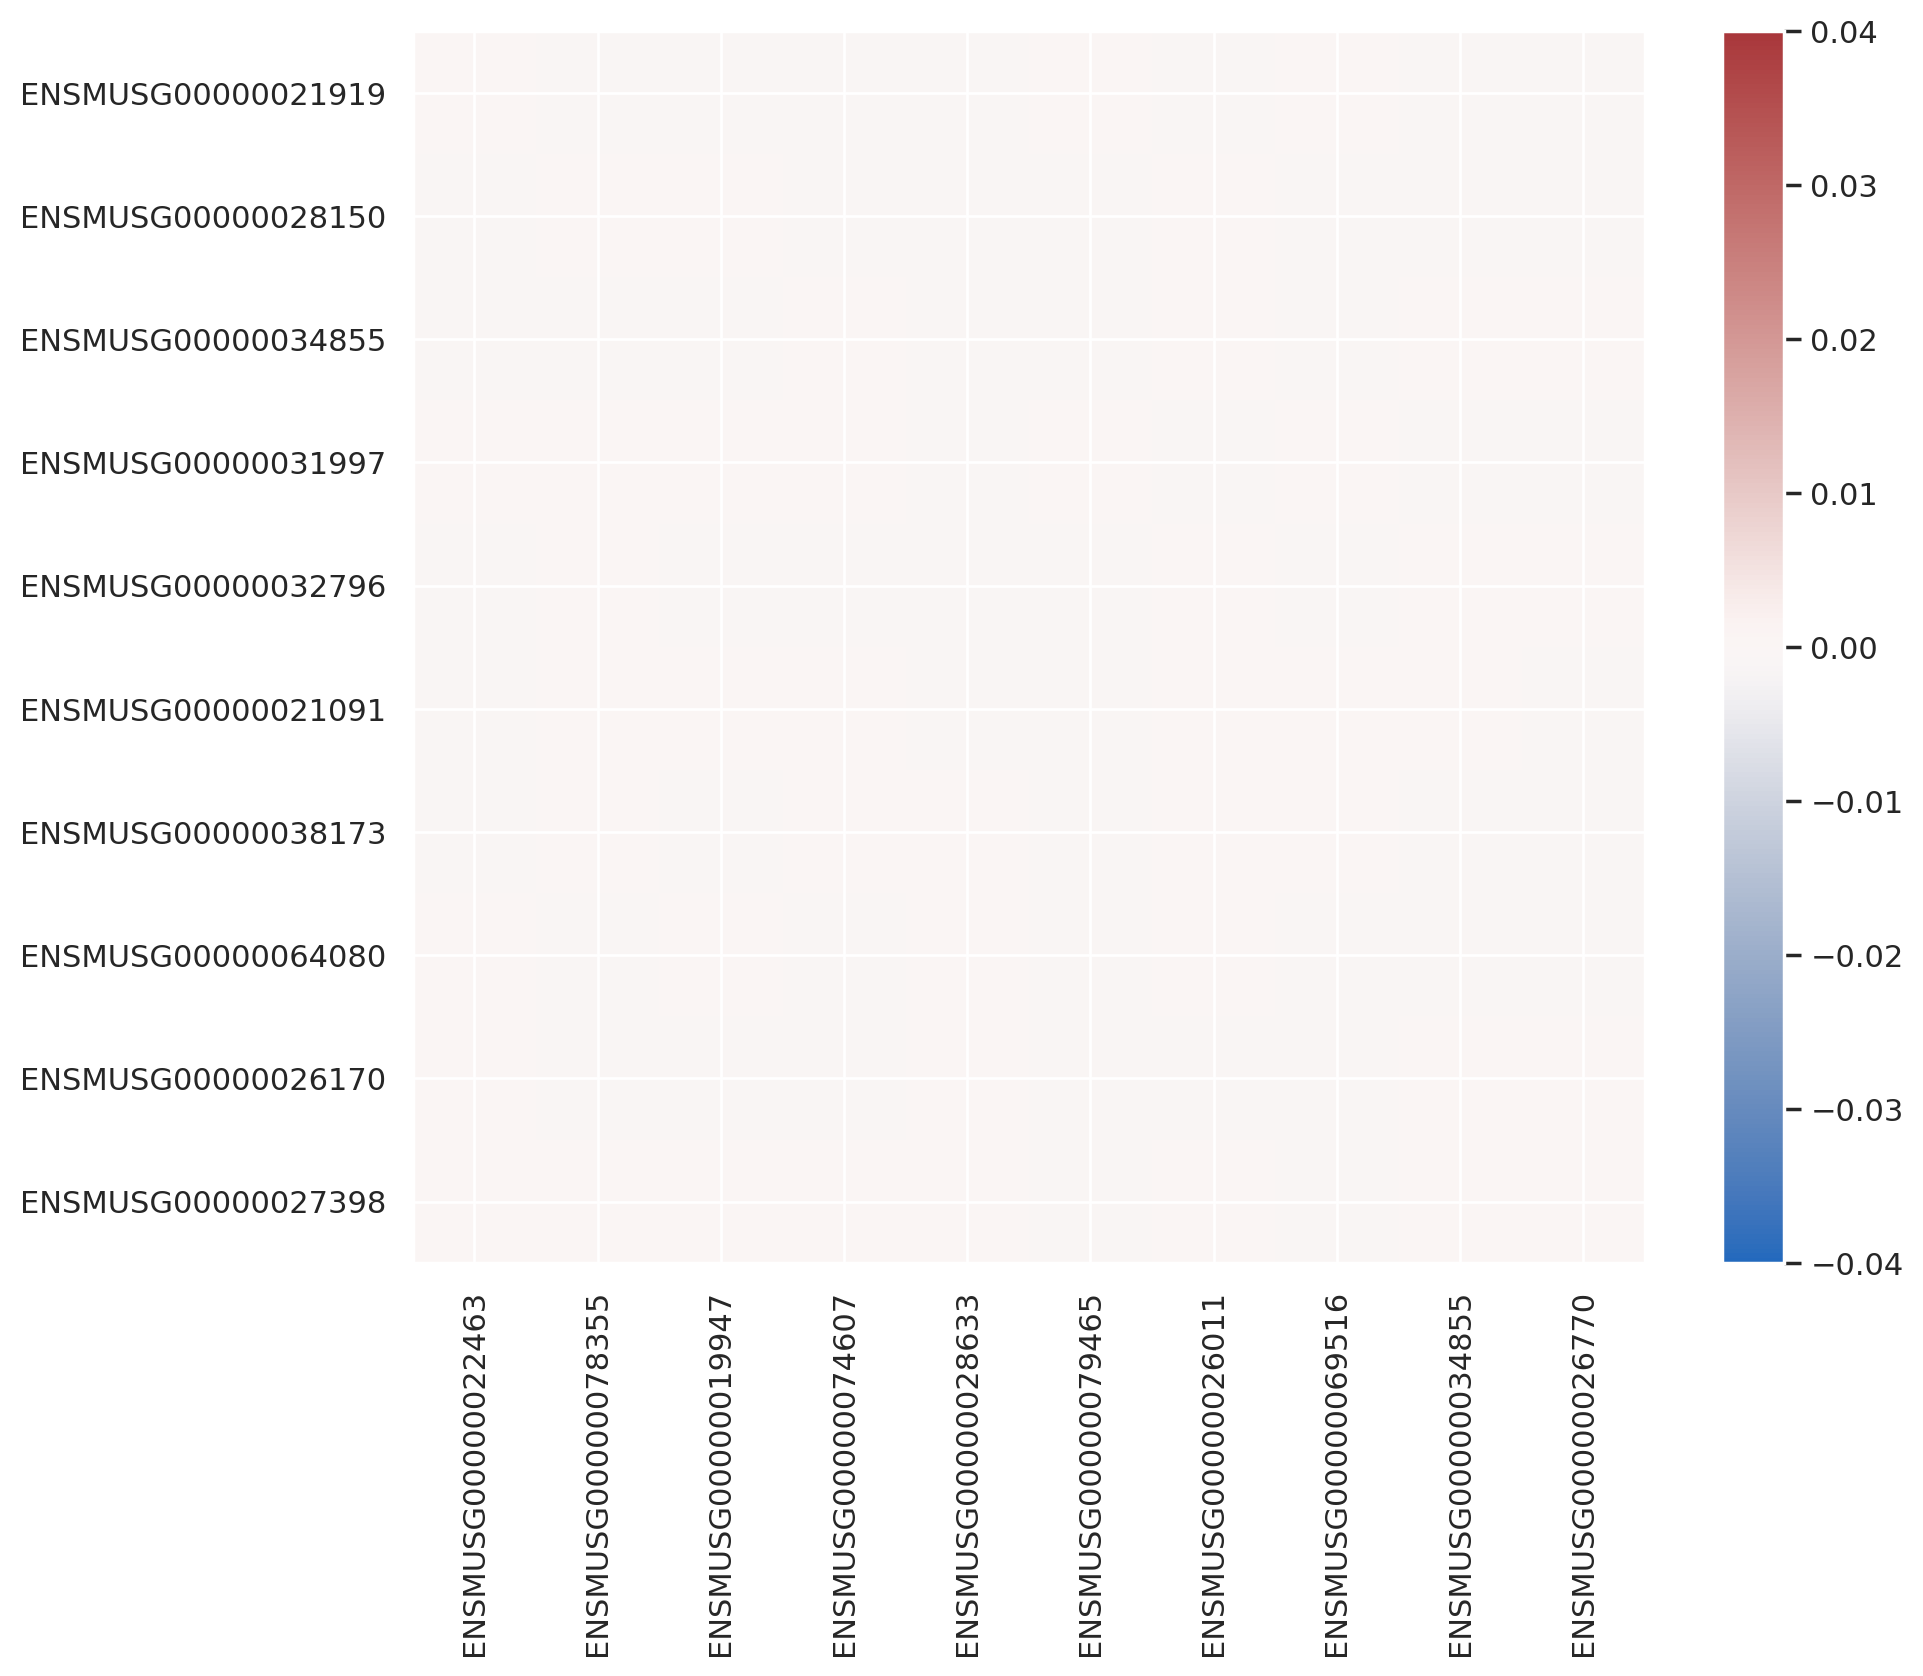

In [27]:
# take out a random patch

PATCH_SIZE = 10

idxCol = np.random.choice(meaningfulMatGR.shape[1], size=PATCH_SIZE, replace=False)
idxRow = np.random.choice(meaningfulMatGR.shape[0], size=PATCH_SIZE, replace=False)

patchMatGR = meaningfulMatGR[idxRow, :][:, idxCol]
patchGeneCol = genesCol[idxCol]
patchGeneRow = genesRow[idxRow]

plt.figure(figsize=(10, 8))
plt.imshow(patchMatGR, cmap='vlag', vmin=-.04, vmax=.04)
plt.colorbar()
plt.xticks(range(PATCH_SIZE), patchGeneCol, rotation=90)
plt.yticks(range(PATCH_SIZE), patchGeneRow)

In [28]:
# # take out a random column

# randColIdx = np.random.choice(meaningfulMatGR.shape[1], size=1, replace=False)
# randCol = meaningfulMatGR[:, randColIdx]
# randGene = genesCol[randColIdx]
# meaningfulY = np.abs(randCol) > THRESHOLD

# randCol = randCol[meaningfulY]

# randGene = randGene[meaningfulY]

# plt.figure(figsize=(10, 8))
# plt.imshow(randCol, cmap='vlag', vmin=-.04, vmax=.04)
# plt.colorbar()
# plt.xticks(range(1), randGene, rotation=90)
# plt.yticks(range(meaningfulMatGR.shape[0]), genesRow)

In [29]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"


/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


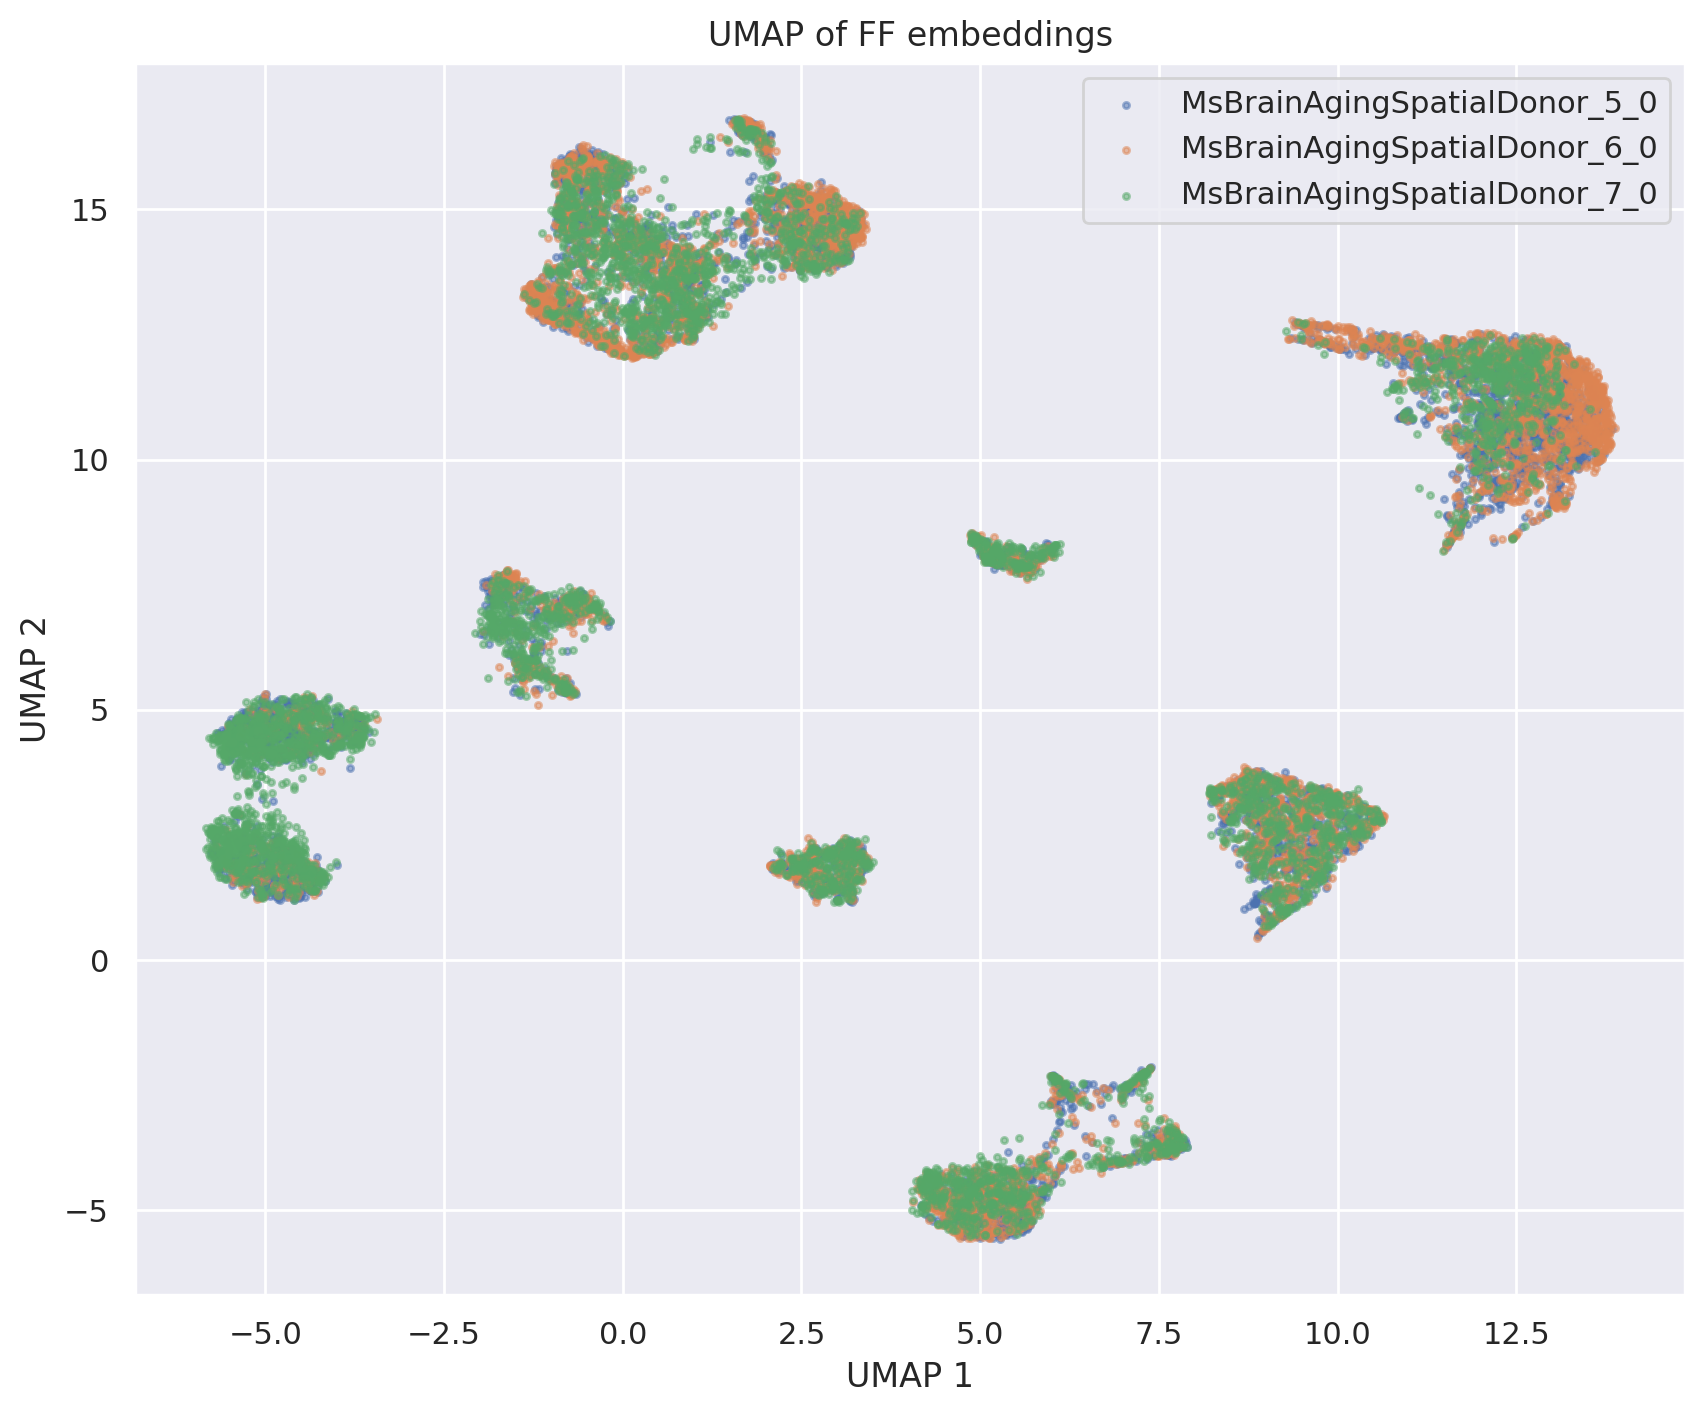

In [30]:
embeddingsFF = []
for Xs in train_Xs:
    embeddingsFF.append(model.getCellEmbedding(Xs))
    
embeddingsFFCat = np.concatenate(embeddingsFF, axis=0)
numCells = [Xs.shape[0] for Xs in train_Xs]

from umap import UMAP

embeddingUmapFF = UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42).fit_transform(embeddingsFFCat)

plt.figure(figsize=(10, 8))
cnt = 0
for i, numCell in enumerate(numCells):
    plt.scatter(embeddingUmapFF[cnt:cnt + numCell, 0], embeddingUmapFF[cnt:cnt + numCell, 1], label=chosen_slices[i], s=5, alpha=0.5)
    cnt += numCell
plt.legend()
plt.title('UMAP of FF embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

## Exp 2: Transformer for embedding

In [54]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "5"

train_Xs = []
chosen_slices = ['MsBrainAgingSpatialDonor_5_0', 'MsBrainAgingSpatialDonor_6_0', 
                 'MsBrainAgingSpatialDonor_7_0']
for i in chosen_slices:
    train_Xs.append(np.array(adata.X[adata.obs['donor_slice'] == i, :]))
    
validate_Xs = []
chosen_donors = ['MsBrainAgingSpatialDonor_8_0']
for i in chosen_donors:
    validate_Xs.append(np.array(adata.X[adata.obs['donor_slice'] == i, :]))
    
_, p = train_Xs[0].shape

class MyDataSet(Data.Dataset):
    def __init__(self, Xs):
        super(MyDataSet, self).__init__()
        self.Xs = [torch.Tensor(X) for X in Xs]
        
    def __len__(self):
        return len(self.Xs)

    def __getitem__(self, idx):
        return self.Xs[idx]

train_data = MyDataSet(train_Xs)
train_loader = Data.DataLoader(train_data, batch_size=1, shuffle=True) 

print("Training data dimensions:")
for i in train_Xs:
    print(i.shape)


Training data dimensions:
(5000, 374)
(5000, 374)
(5000, 374)


In [55]:
validate_data = MyDataSet(validate_Xs)
validate_loader = Data.DataLoader(validate_data, batch_size=1, shuffle=True)

print("Validation data dimensions:")
for i in validate_Xs:
    print(i.shape)


Validation data dimensions:
(5000, 374)


In [56]:
embed_config = {
    'embedType': 'transformer',
    'default': True,
    'd_input': p,
    'n_layers': 1,
}

model = kuanglu.Model(d_gene=p, 
                      d_denoise = [p], 
                      d_quality=[512, 256, 1], 
                      lbd=1.,
                      embed_config=embed_config,
                      ).to('cuda')


In [57]:
rec = model.fit('denoised', train_loader, validate_loader, [0, 500],
                fix=['embed', 'qualify', 'smooth', 'interact'], lr=1e-4)
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [500, 750],
                                           fix=['denoise', 'interact'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [750, 1000],
                                           fix=['interact'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [1000, 1250],
                                           fix=['denoise', 'embed', 'qualify', 'smooth'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [1250, 1500], lr=1e-4))


Epoch 0001 Train MSE 0.978 Validate MSE 1.016 Raw MSE 0.993
Epoch 0002 Train MSE 0.986 Validate MSE 1.030 Raw MSE 1.008


/home/caoyufan/kuanglu/examples/../kuanglu/model.py:312: UserWarning: Parameter containing:
tensor(100., device='cuda:0') is already fixed. They will be unfixed when exiting this function.
  warnings.warn(f"{param} is already fixed. They will be unfixed when exiting this function.")


Epoch 0003 Train MSE 0.976 Validate MSE 1.036 Raw MSE 1.019
Epoch 0004 Train MSE 0.979 Validate MSE 1.043 Raw MSE 1.020
Epoch 0005 Train MSE 0.971 Validate MSE 1.038 Raw MSE 1.018
Epoch 0006 Train MSE 0.960 Validate MSE 1.043 Raw MSE 1.024


Epoch 0007 Train MSE 0.953 Validate MSE 1.037 Raw MSE 1.012
Epoch 0008 Train MSE 0.962 Validate MSE 1.025 Raw MSE 1.004
Epoch 0009 Train MSE 0.944 Validate MSE 1.045 Raw MSE 1.023
Epoch 0010 Train MSE 0.965 Validate MSE 1.049 Raw MSE 1.031
Epoch 0011 Train MSE 0.959 Validate MSE 1.018 Raw MSE 0.998
Epoch 0012 Train MSE 0.964 Validate MSE 1.035 Raw MSE 1.014
Epoch 0013 Train MSE 0.953 Validate MSE 1.037 Raw MSE 1.013
Epoch 0014 Train MSE 0.951 Validate MSE 0.987 Raw MSE 0.963
Epoch 0015 Train MSE 0.943 Validate MSE 1.049 Raw MSE 1.027
Epoch 0016 Train MSE 0.970 Validate MSE 1.028 Raw MSE 1.007
Epoch 0017 Train MSE 0.946 Validate MSE 1.021 Raw MSE 1.000
Epoch 0018 Train MSE 0.945 Validate MSE 1.033 Raw MSE 1.011
Epoch 0019 Train MSE 0.945 Validate MSE 1.062 Raw MSE 1.040
Epoch 0020 Train MSE 0.941 Validate MSE 1.031 Raw MSE 1.013
Epoch 0021 Train MSE 0.949 Validate MSE 1.029 Raw MSE 1.009
Epoch 0022 Train MSE 0.949 Validate MSE 1.049 Raw MSE 1.026
Epoch 0023 Train MSE 0.934 Validate MSE 

Text(0, 0.5, 'MSE')

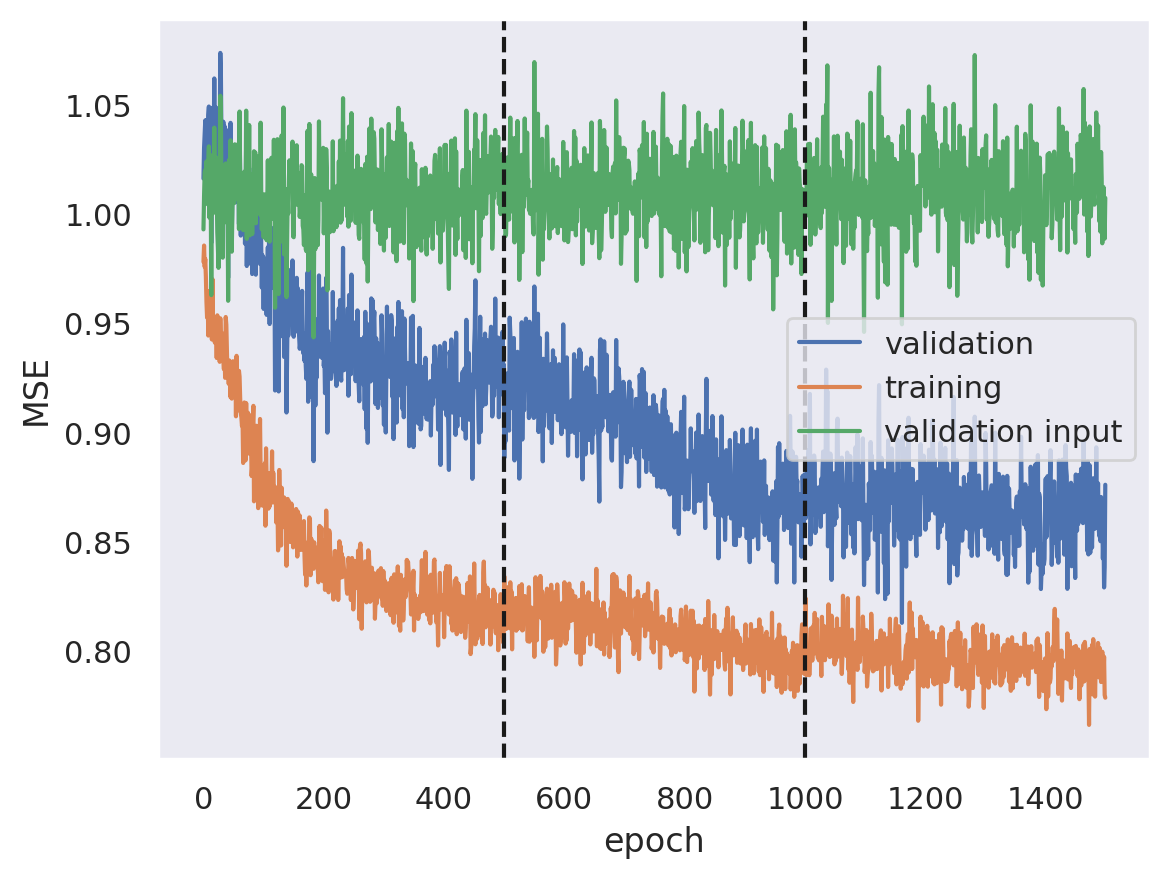

In [58]:
plt.plot(rec['validate_epoch'], rec['validate_mse'], label='validation')
plt.plot(rec['train_epoch'], rec['train_mse'], label='training')
plt.plot(rec['validate_epoch'], rec['raw_mse'], label='validation input')
plt.legend()
plt.grid()
plt.axvline(500, ls='--', c='k')
plt.axvline(1000, ls='--', c='k')
plt.xlabel('epoch')
plt.ylabel('MSE')


In [59]:
mse_df = pd.DataFrame({'epoch': rec['validate_epoch'], 'mse': rec['validate_mse']})

def epoch2stage(x):
    if x < 250: return 'pre-denoise'
    elif x < 500: return 'denoise'
    elif x < 750: return 'pre-denoise-smooth'
    elif x < 1000: return 'denoise-smooth'
    elif x < 1250: return 'pre-denoise-smooth-enhance'
    elif x < 1500: return 'denoise-smooth-enhance'
    else: raise NotImplementedError('x >= 1500 not allowed')

mse_df['stage'] = mse_df['epoch'].apply(epoch2stage)
mse_df


epoch       mse                   stage
0         0  1.016231             pre-denoise
1         1  1.030267             pre-denoise
2         2  1.036343             pre-denoise
3         3  1.042882             pre-denoise
4         4  1.038409             pre-denoise
...     ...       ...                     ...
1495   1495  0.842213  denoise-smooth-enhance
1496   1496  0.855345  denoise-smooth-enhance
1497   1497  0.829003  denoise-smooth-enhance
1498   1498  0.838307  denoise-smooth-enhance
1499   1499  0.876023  denoise-smooth-enhance

[1500 rows x 3 columns]

/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


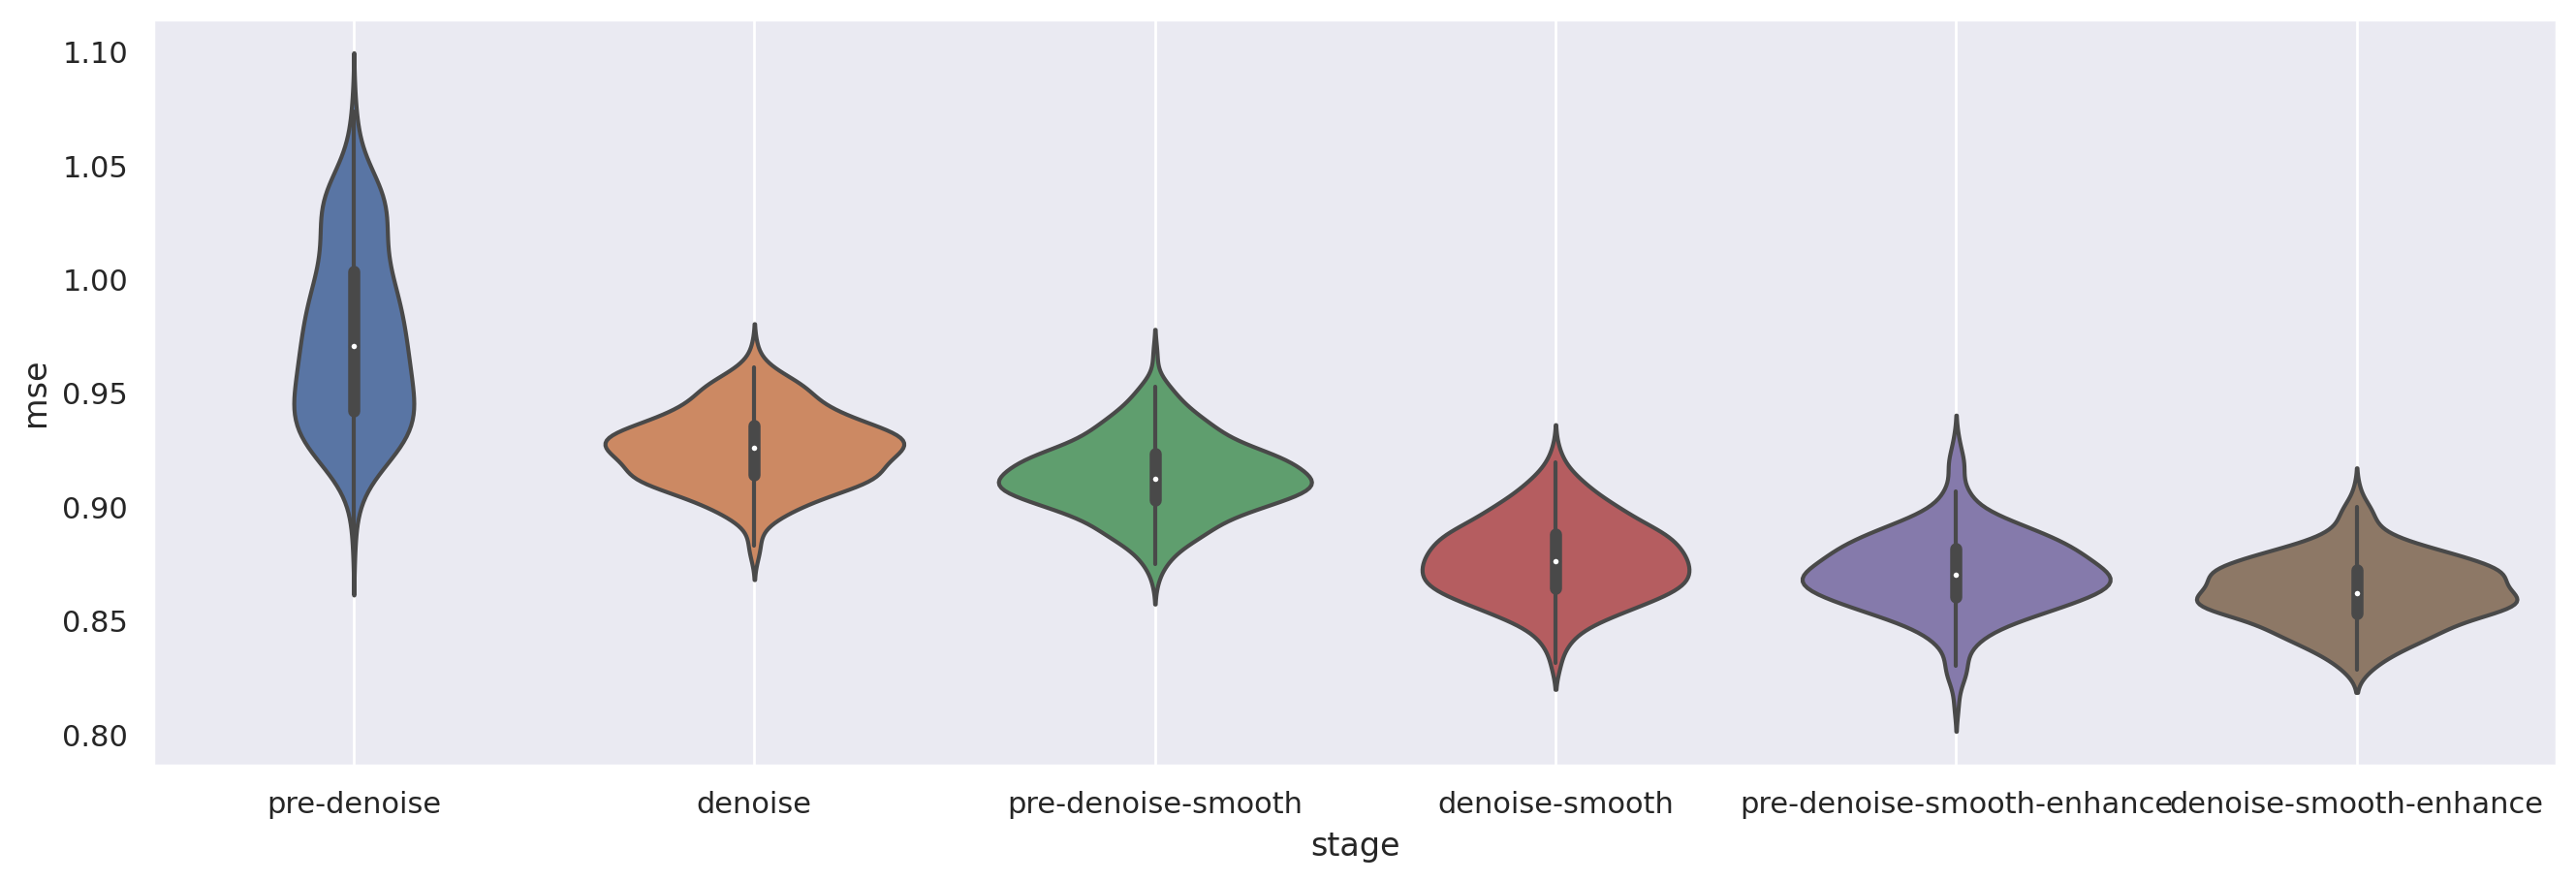

In [60]:
# sns.violinplot(mse_df[~mse_df['stage'].str.contains('pre-')], x='stage', y='mse')
%config InlineBackend.figure_format ='retina'
plt.figure(figsize=(16, 5))
sns.violinplot(mse_df, x='stage', y='mse')
plt.grid()


In [61]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'])

print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise') / sum(mse_df['stage'] == 'denoise-smooth'))


p = 5.862571205325525e-77 f = 0.979904


In [62]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth-enhance', 'mse'])
print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise-smooth') / sum(mse_df['stage'] == 'denoise-smooth-enhance'))


p = 1.5078392908856008e-18 f = 0.727168


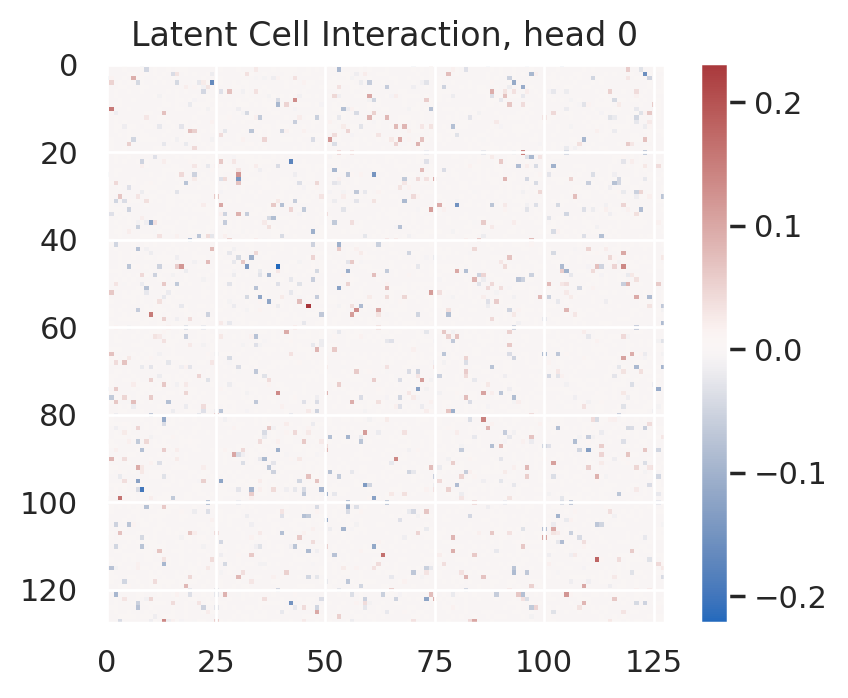

In [63]:
# Plot heatmap of the parameters in cell interaction module

weight_CIs = []
for head in range(len(model.cell_interacts)):
    weight_CIs.append(model.cell_interacts[head].transform.data)

plt.figure(figsize=(10, 8))
for i, weight_CI in enumerate(weight_CIs):
    weight_array = weight_CI.cpu().numpy()
    plt.subplot(2, 2, i + 1)
    plt.imshow(weight_array, cmap='vlag')
    plt.colorbar()
    plt.title(f'Latent Cell Interaction, head {i}')
plt.show()


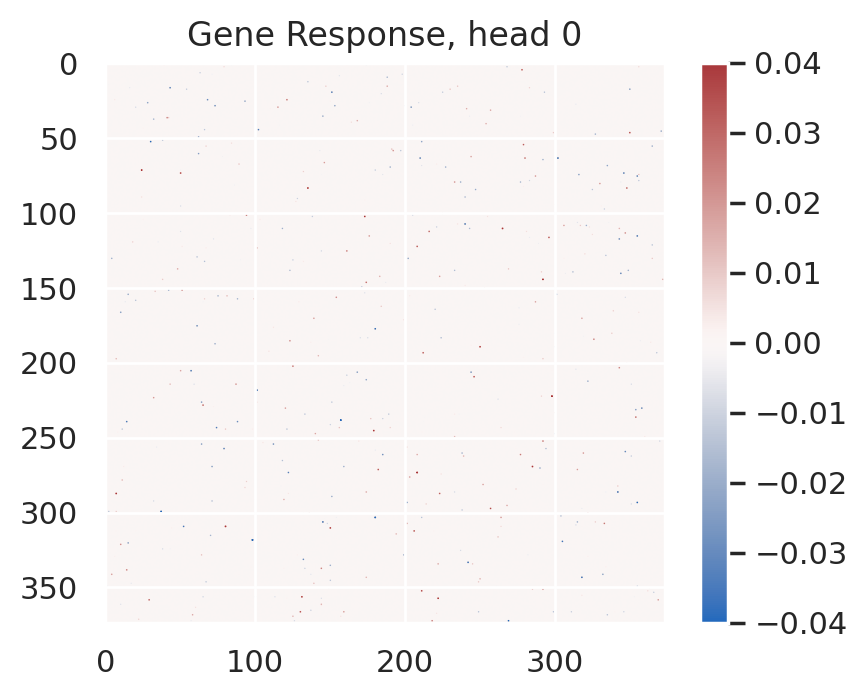

In [64]:
# Plot heatmap of the parameters in gene response module

weight_GRs = []
for head in range(len(model.cell_interacts)):
    weight_GRs.append(model.cell_interacts[head].gene_response.data)

plt.figure(figsize=(10, 8))
for i, weight_GR in enumerate(weight_GRs):
    weight_array = weight_GR.cpu().numpy()
    plt.subplot(2, 2, i + 1)
    plt.imshow(weight_array, cmap='vlag', vmin=-.04, vmax=.04)
    plt.colorbar()
    plt.title(f'Gene Response, head {i}')
plt.show()


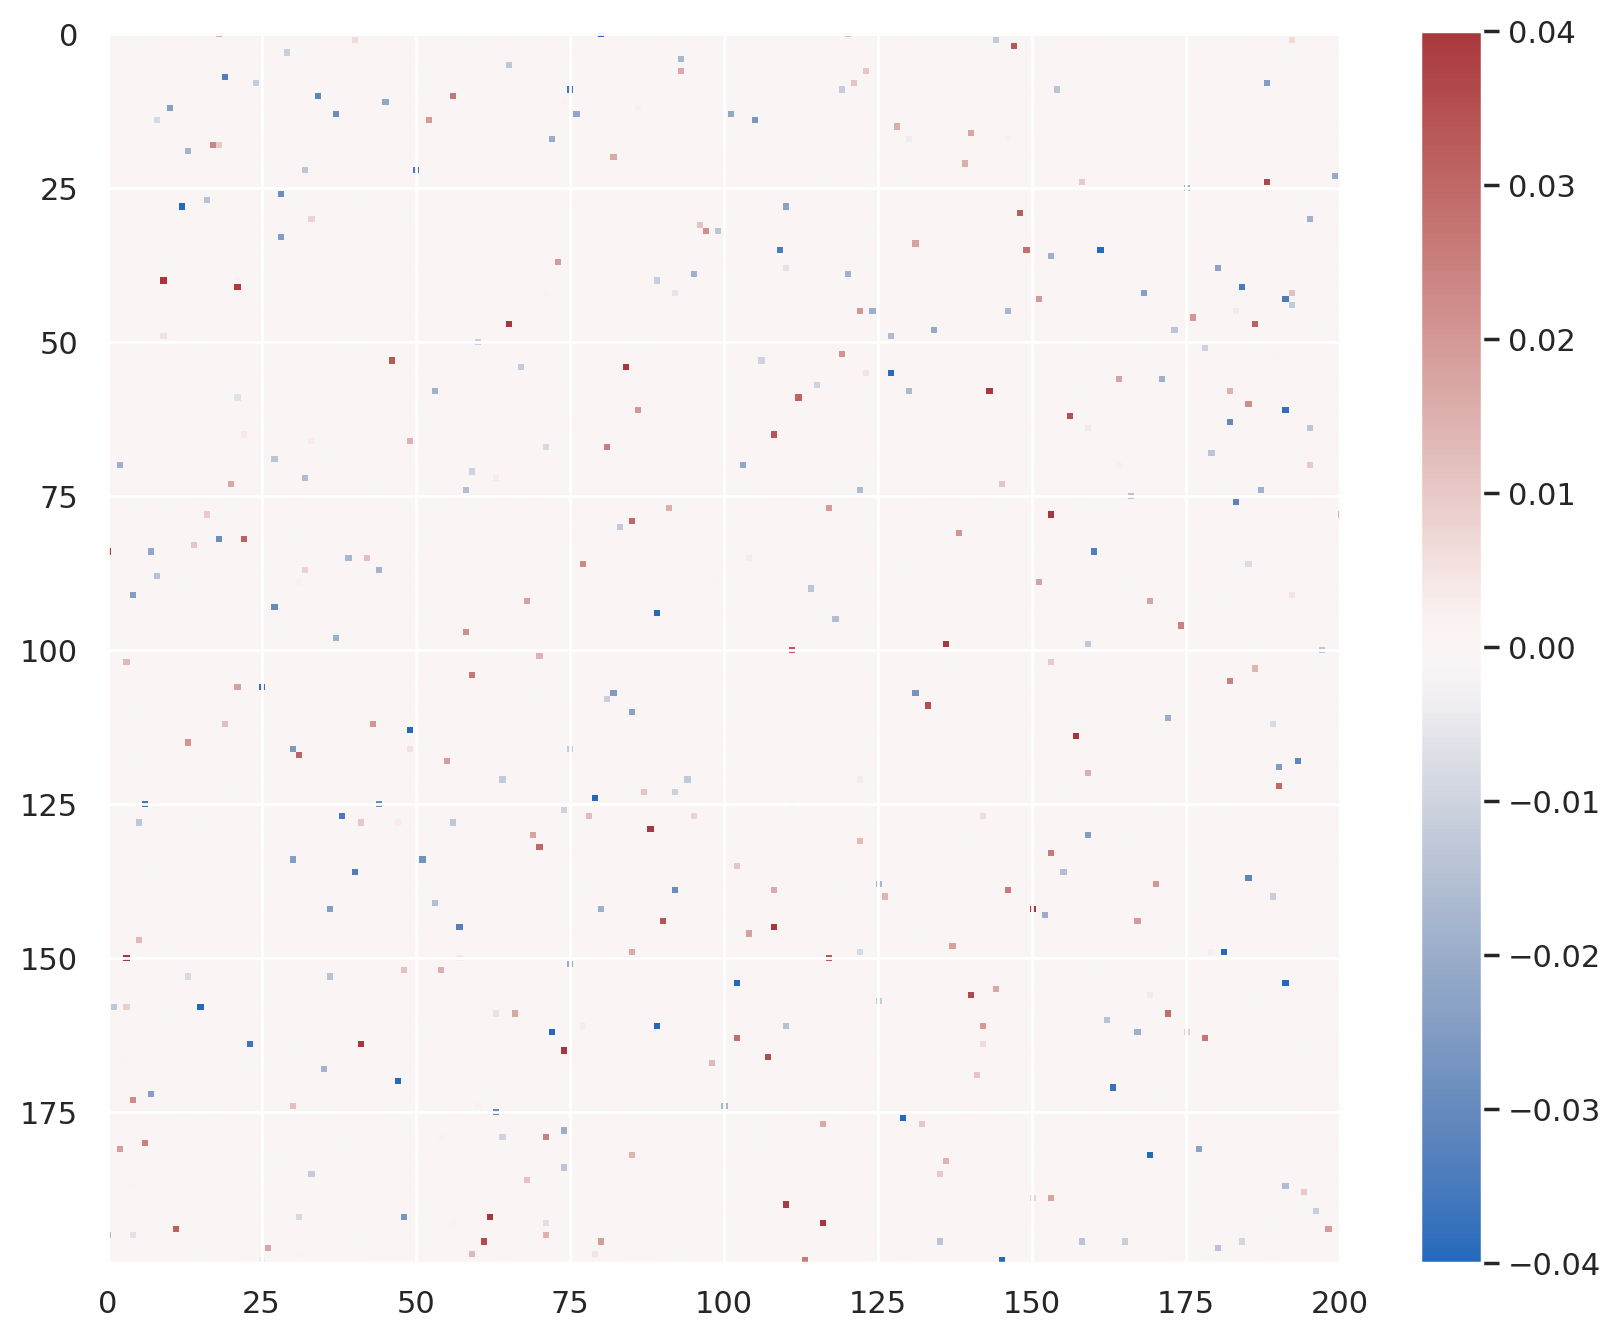

In [65]:
# Extract meaningful weights from Gene Response
THRESHOLD = 0.01

matGR = model.cell_interacts[0].gene_response.data.cpu().numpy()
col_max = np.max(np.abs(matGR), axis=0)
row_max = np.max(np.abs(matGR), axis=1)

meaningfulCols = np.where(col_max > THRESHOLD)[0]
meaningfulRows = np.where(row_max > THRESHOLD)[0]

meaningfulMatGR = matGR[meaningfulRows, :][:, meaningfulCols]

# meaningfulMatGR = np.clip(meaningfulMatGR, -.04, .04)

plt.figure(figsize=(10, 8))
plt.imshow(meaningfulMatGR, cmap='vlag', vmin=-.04, vmax=.04)
plt.colorbar()


In [66]:
# Find the indices of highest absolute values in the meaningfulMatGR

topK = 10
topK_indices = np.argsort(np.abs(matGR), axis=None)[-topK:]

topK_indices = np.unravel_index(topK_indices, matGR.shape)

topK_indices


(array([269,   0, 299, 110, 309, 222, 303, 238, 273, 318]),
 array([285, 159,  37, 265,  80, 298, 180, 157, 208,  98]))

In [67]:
np.abs(matGR)[topK_indices]


array([0.05247818, 0.05453239, 0.05588276, 0.0575747 , 0.06146791,
       0.06405322, 0.0672624 , 0.06930736, 0.0710706 , 0.0929606 ],
      dtype=float32)

In [68]:
# check the corresponding genes

LR_pairs = []

for i in range(topK):
    LR_pairs.append((adata.var.index[topK_indices[1][i]], 
                     adata.var.index[topK_indices[0][i]]))

LR_pairs


[('ENSMUSG00000046159', 'ENSMUSG00000008575'),
 ('ENSMUSG00000010175', 'ENSMUSG00000018381'),
 ('ENSMUSG00000022041', 'ENSMUSG00000025584'),
 ('ENSMUSG00000037138', 'ENSMUSG00000026770'),
 ('ENSMUSG00000026787', 'ENSMUSG00000015149'),
 ('ENSMUSG00000034098', 'ENSMUSG00000028565'),
 ('ENSMUSG00000036814', 'ENSMUSG00000028634'),
 ('ENSMUSG00000031425', 'ENSMUSG00000040170'),
 ('ENSMUSG00000011171', 'ENSMUSG00000066551'),
 ('ENSMUSG00000055170', 'ENSMUSG00000021972')]

In [69]:
import pandas as pd

lr_pairs = pd.read_csv('./mouse_lr_pair.csv')

lgID = lr_pairs['ligand_ensembl_gene_id']
rpID = lr_pairs['receptor_ensembl_gene_id']

lrID = pd.concat([lgID, rpID], axis=1)
# lrID

geneIDBank = set(adata.var.index)

# filter out the genes that are not in the dataset

lrID = lrID[lrID['ligand_ensembl_gene_id'].isin(geneIDBank) &
            lrID['receptor_ensembl_gene_id'].isin(geneIDBank)]
lrID


ligand_ensembl_gene_id receptor_ensembl_gene_id
26       ENSMUSG00000035385       ENSMUSG00000049103
50       ENSMUSG00000000869       ENSMUSG00000026770
52       ENSMUSG00000000869       ENSMUSG00000031304
275      ENSMUSG00000017344       ENSMUSG00000026768
323      ENSMUSG00000019772       ENSMUSG00000022206
334      ENSMUSG00000019997       ENSMUSG00000020122
339      ENSMUSG00000019997       ENSMUSG00000030786
467      ENSMUSG00000024164       ENSMUSG00000026616
469      ENSMUSG00000024164       ENSMUSG00000030724
470      ENSMUSG00000024164       ENSMUSG00000030786
1144     ENSMUSG00000024164       ENSMUSG00000000290
1153     ENSMUSG00000051439       ENSMUSG00000000290
1212     ENSMUSG00000049796       ENSMUSG00000003476
1296     ENSMUSG00000019772       ENSMUSG00000011171
1356     ENSMUSG00000025746       ENSMUSG00000020122
1357     ENSMUSG00000028364       ENSMUSG00000020122
1473     ENSMUSG00000002985       ENSMUSG00000023992
1557     ENSMUSG00000028364       ENSMUSG00000026768
1653     ENSMUSG00000002985       ENSMUSG00000015243
1900     ENSMUSG00000066551       ENSMUSG00000030786

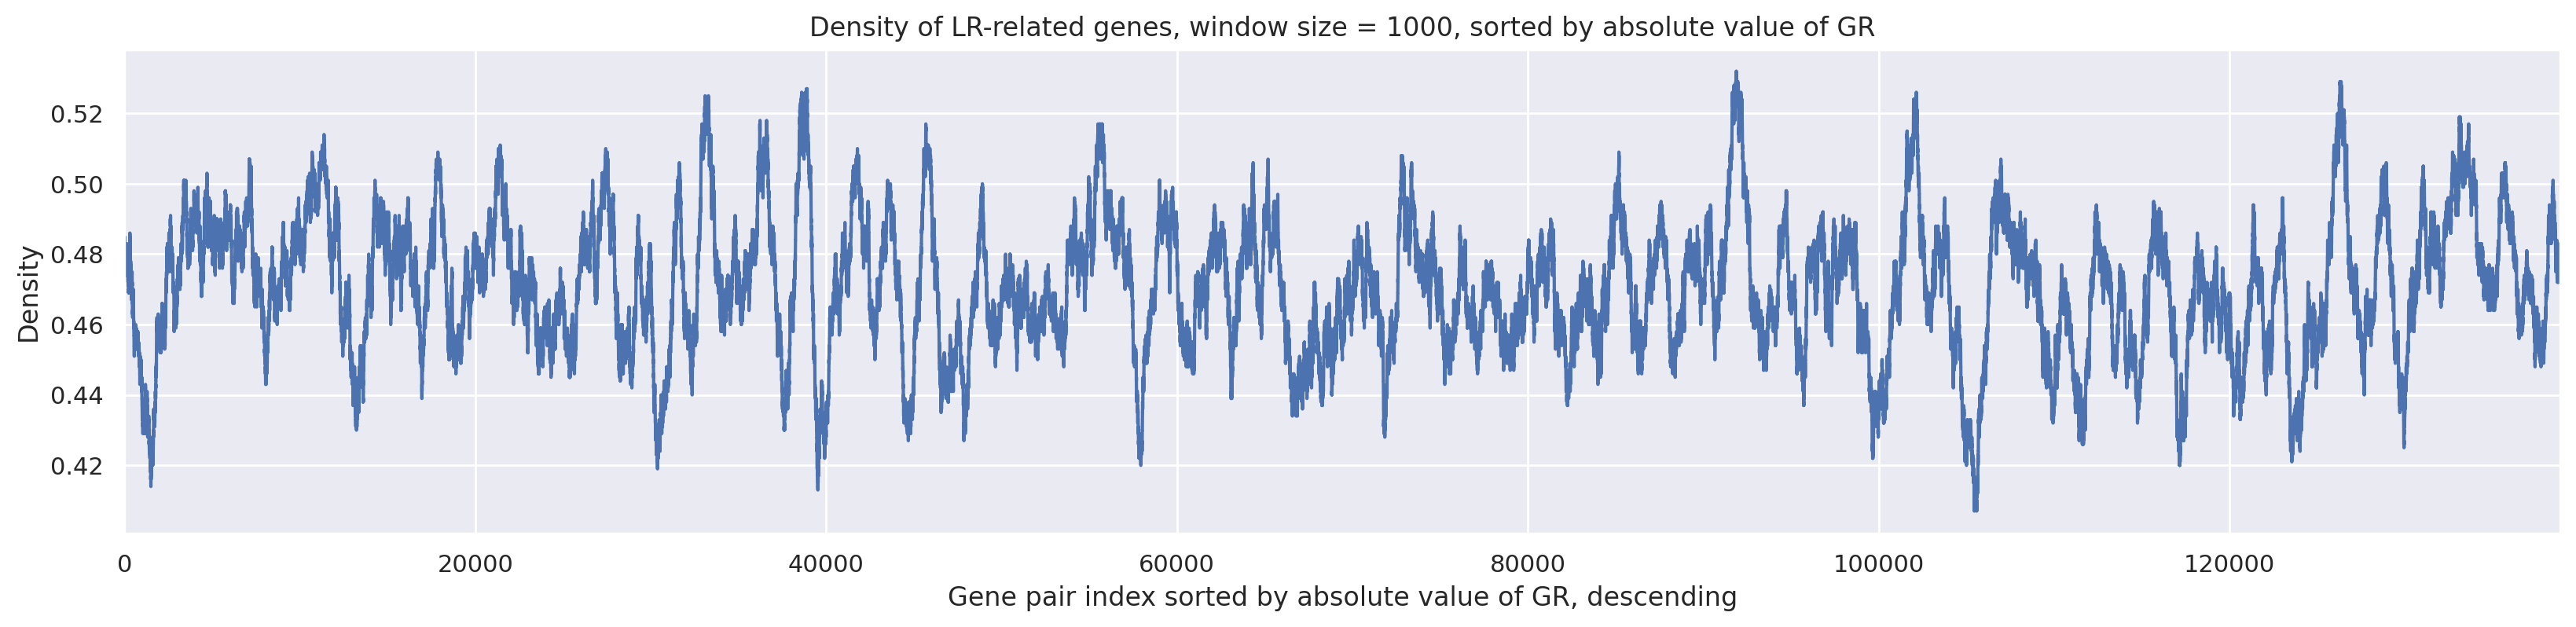

In [70]:
ranked_indices = np.argsort(np.abs(matGR), axis=None)
ranked_indices = np.unravel_index(ranked_indices, matGR.shape)

LR_related_genes = set(lgID) | set(rpID)

hasRelatedGenes = []

for indices in zip(ranked_indices[0], ranked_indices[1]):
    cnt = 0
    if adata.var.index[indices[0]] in LR_related_genes:
        cnt += 1
    if adata.var.index[indices[1]] in LR_related_genes:
        cnt += 1
    hasRelatedGenes.append(cnt)

hasRelatedGenes = np.array(hasRelatedGenes)

WINDOW_SIZE = 1000

density = []

for i in range(len(hasRelatedGenes) - WINDOW_SIZE):
    density.append(np.mean(hasRelatedGenes[i:i + WINDOW_SIZE]))
    
%config InlineBackend.figure_format ='retina'
sns.set()
plt.figure(figsize=(20, 4));
plt.plot(density);
plt.title(f'Density of LR-related genes, window size = {WINDOW_SIZE}, sorted by absolute value of GR');
plt.xlim(0, len(hasRelatedGenes) - WINDOW_SIZE);
plt.xlabel('Gene pair index sorted by absolute value of GR, descending');
plt.ylabel('Density');


In [71]:
genesCol = adata.var_names[meaningfulCols]
genesRow = adata.var_names[meaningfulRows]

genesCol, genesRow


(Index(['ENSMUSG00000018381', 'ENSMUSG00000020178', 'ENSMUSG00000017390',
        'ENSMUSG00000037010', 'ENSMUSG00000048251', 'ENSMUSG00000031375',
        'ENSMUSG00000036887', 'ENSMUSG00000036896', 'ENSMUSG00000003657',
        'ENSMUSG00000049103',
        ...
        'ENSMUSG00000026083', 'ENSMUSG00000023868', 'ENSMUSG00000041959',
        'ENSMUSG00000045875', 'ENSMUSG00000040612', 'ENSMUSG00000020160',
        'ENSMUSG00000050711', 'ENSMUSG00000044647', 'ENSMUSG00000024238',
        'ENSMUSG00000024501'],
       dtype='object', length=201),
 Index(['ENSMUSG00000018381', 'ENSMUSG00000020178', 'ENSMUSG00000017390',
        'ENSMUSG00000038115', 'ENSMUSG00000060802', 'ENSMUSG00000021835',
        'ENSMUSG00000036896', 'ENSMUSG00000045532', 'ENSMUSG00000024164',
        'ENSMUSG00000028222',
        ...
        'ENSMUSG00000019880', 'ENSMUSG00000031997', 'ENSMUSG00000023868',
        'ENSMUSG00000055415', 'ENSMUSG00000041959', 'ENSMUSG00000031839',
        'ENSMUSG00000020160', 'ENSM

In [72]:
meaningfulMatGR.shape


(200, 201)

([<matplotlib.axis.YTick at 0x7fcf4c239590>,
 [Text(0, 0, 'ENSMUSG00000112276'),
  Text(0, 1, 'ENSMUSG00000027398'),
  Text(0, 2, 'ENSMUSG00000046764'),
  Text(0, 3, 'ENSMUSG00000021939'),
  Text(0, 4, 'ENSMUSG00000063873'),
  Text(0, 5, 'ENSMUSG00000020383'),
  Text(0, 6, 'ENSMUSG00000034485'),
  Text(0, 7, 'ENSMUSG00000055435'),
  Text(0, 8, 'ENSMUSG00000035158'),
  Text(0, 9, 'ENSMUSG00000062372')])

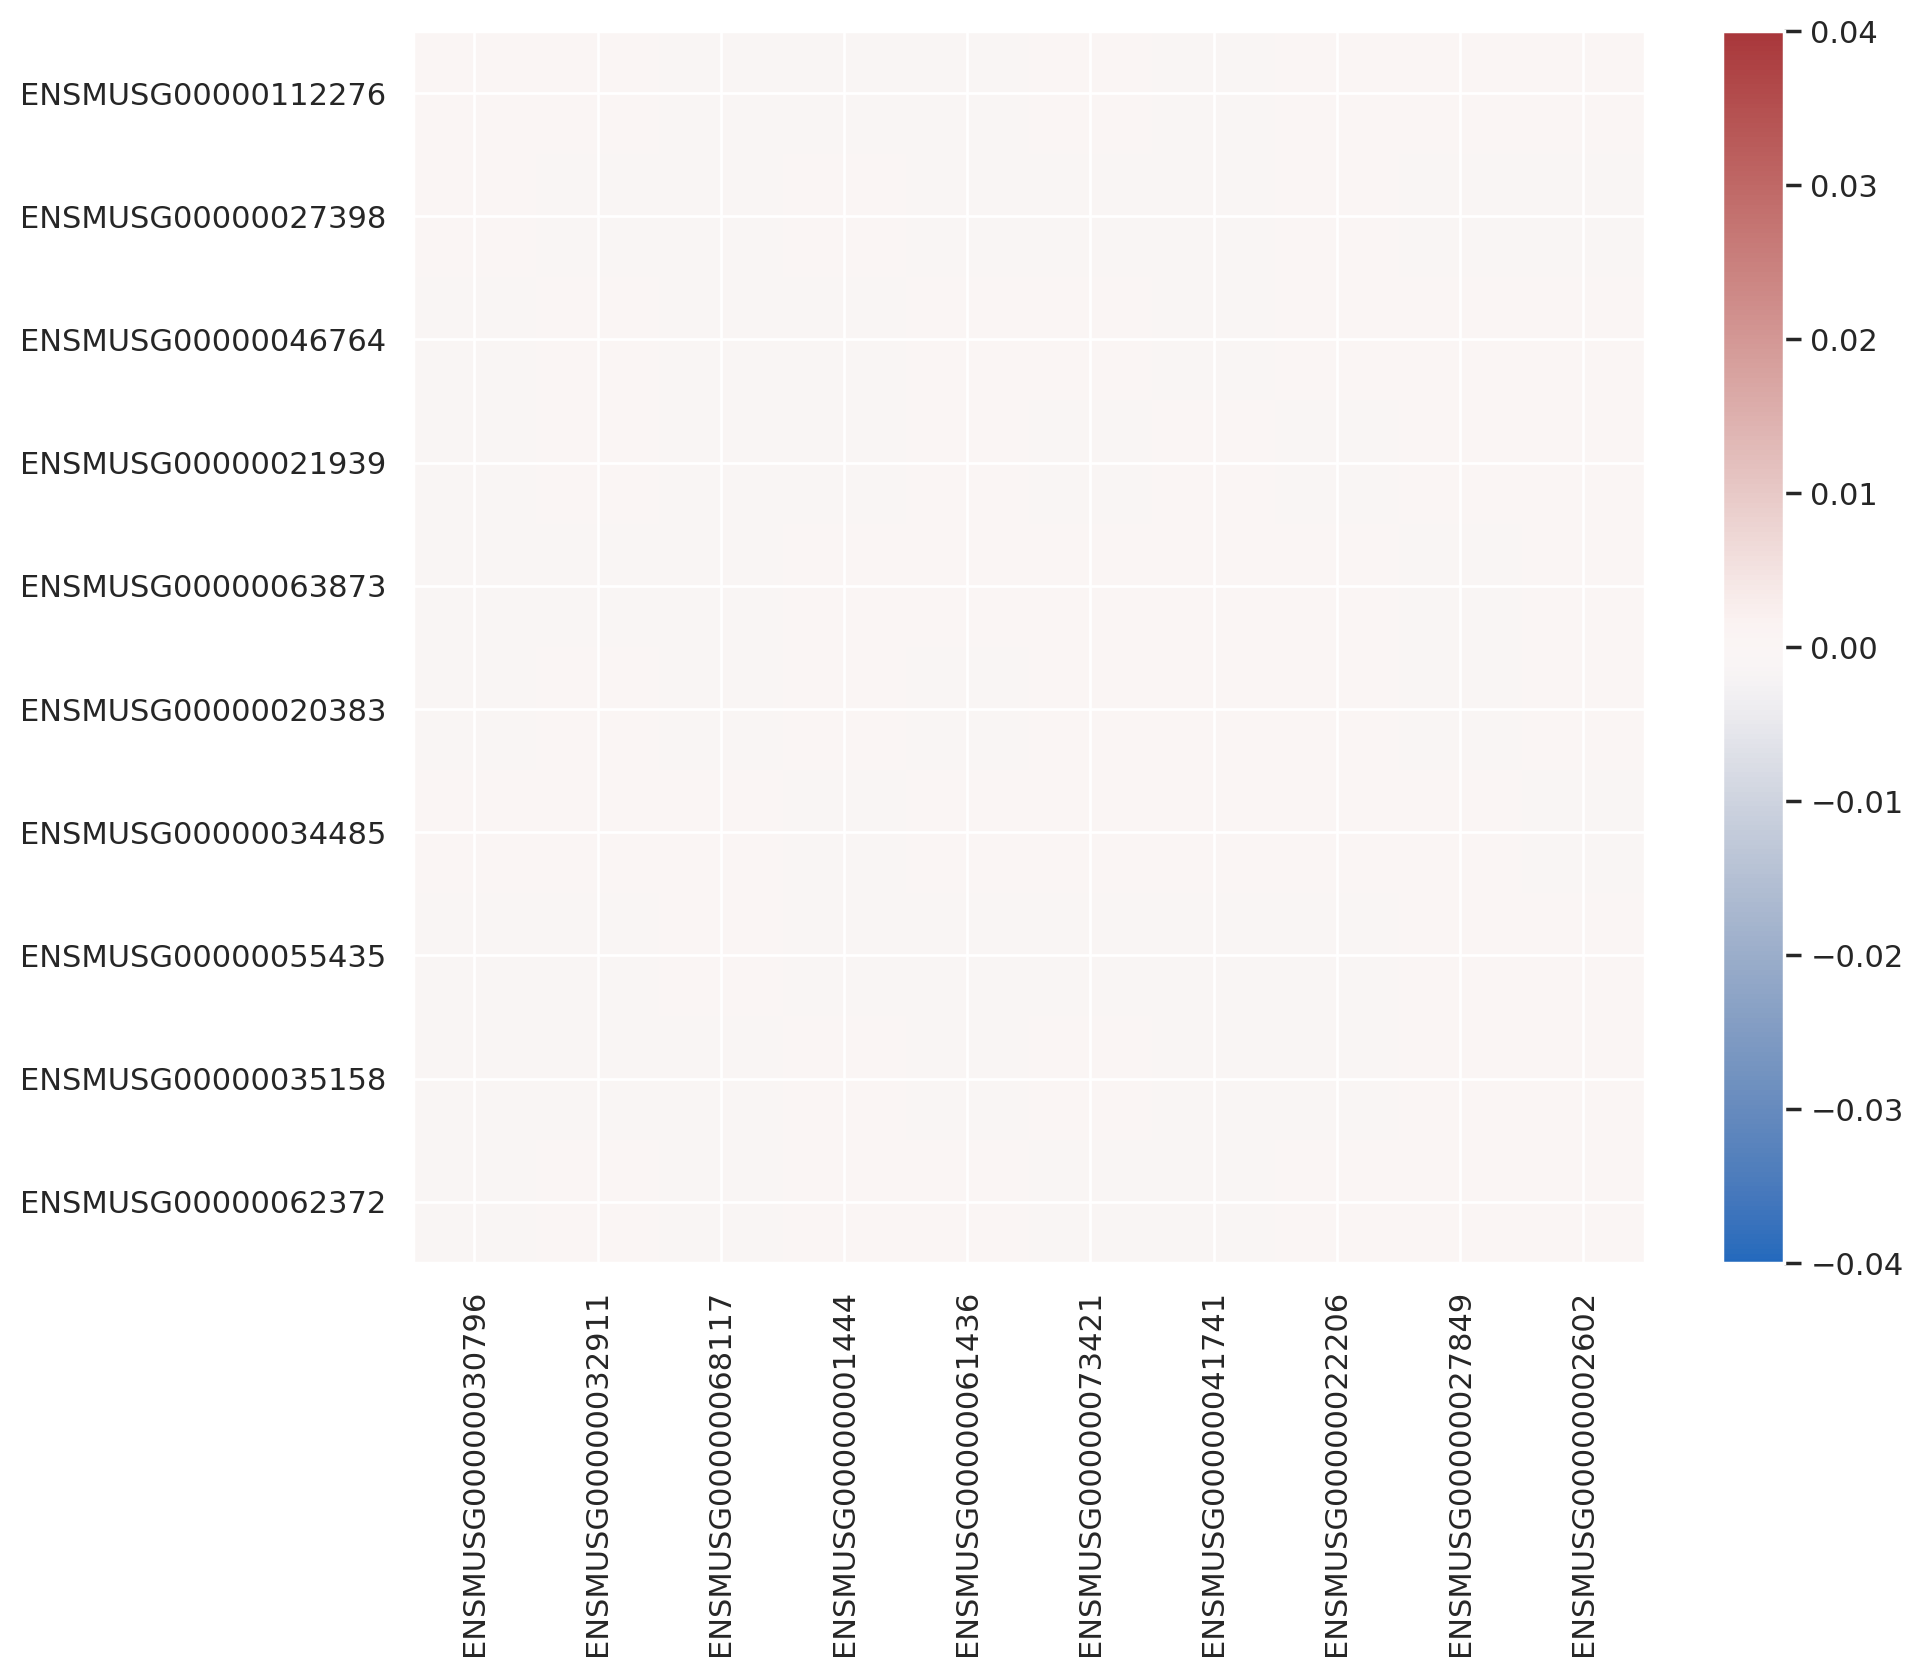

In [73]:
# take out a random patch

PATCH_SIZE = 10

idxCol = np.random.choice(meaningfulMatGR.shape[1], size=PATCH_SIZE, replace=False)
idxRow = np.random.choice(meaningfulMatGR.shape[0], size=PATCH_SIZE, replace=False)

patchMatGR = meaningfulMatGR[idxRow, :][:, idxCol]
patchGeneCol = genesCol[idxCol]
patchGeneRow = genesRow[idxRow]

plt.figure(figsize=(10, 8))
plt.imshow(patchMatGR, cmap='vlag', vmin=-.04, vmax=.04)
plt.colorbar()
plt.xticks(range(PATCH_SIZE), patchGeneCol, rotation=90)
plt.yticks(range(PATCH_SIZE), patchGeneRow)


In [74]:
# # take out a random column

# randColIdx = np.random.choice(meaningfulMatGR.shape[1], size=1, replace=False)
# randCol = meaningfulMatGR[:, randColIdx]
# randGene = genesCol[randColIdx]
# meaningfulY = np.abs(randCol) > THRESHOLD

# randCol = randCol[meaningfulY]

# randGene = randGene[meaningfulY]

# plt.figure(figsize=(10, 8))
# plt.imshow(randCol, cmap='vlag', vmin=-.04, vmax=.04)
# plt.colorbar()
# plt.xticks(range(1), randGene, rotation=90)
# plt.yticks(range(meaningfulMatGR.shape[0]), genesRow)
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"



/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


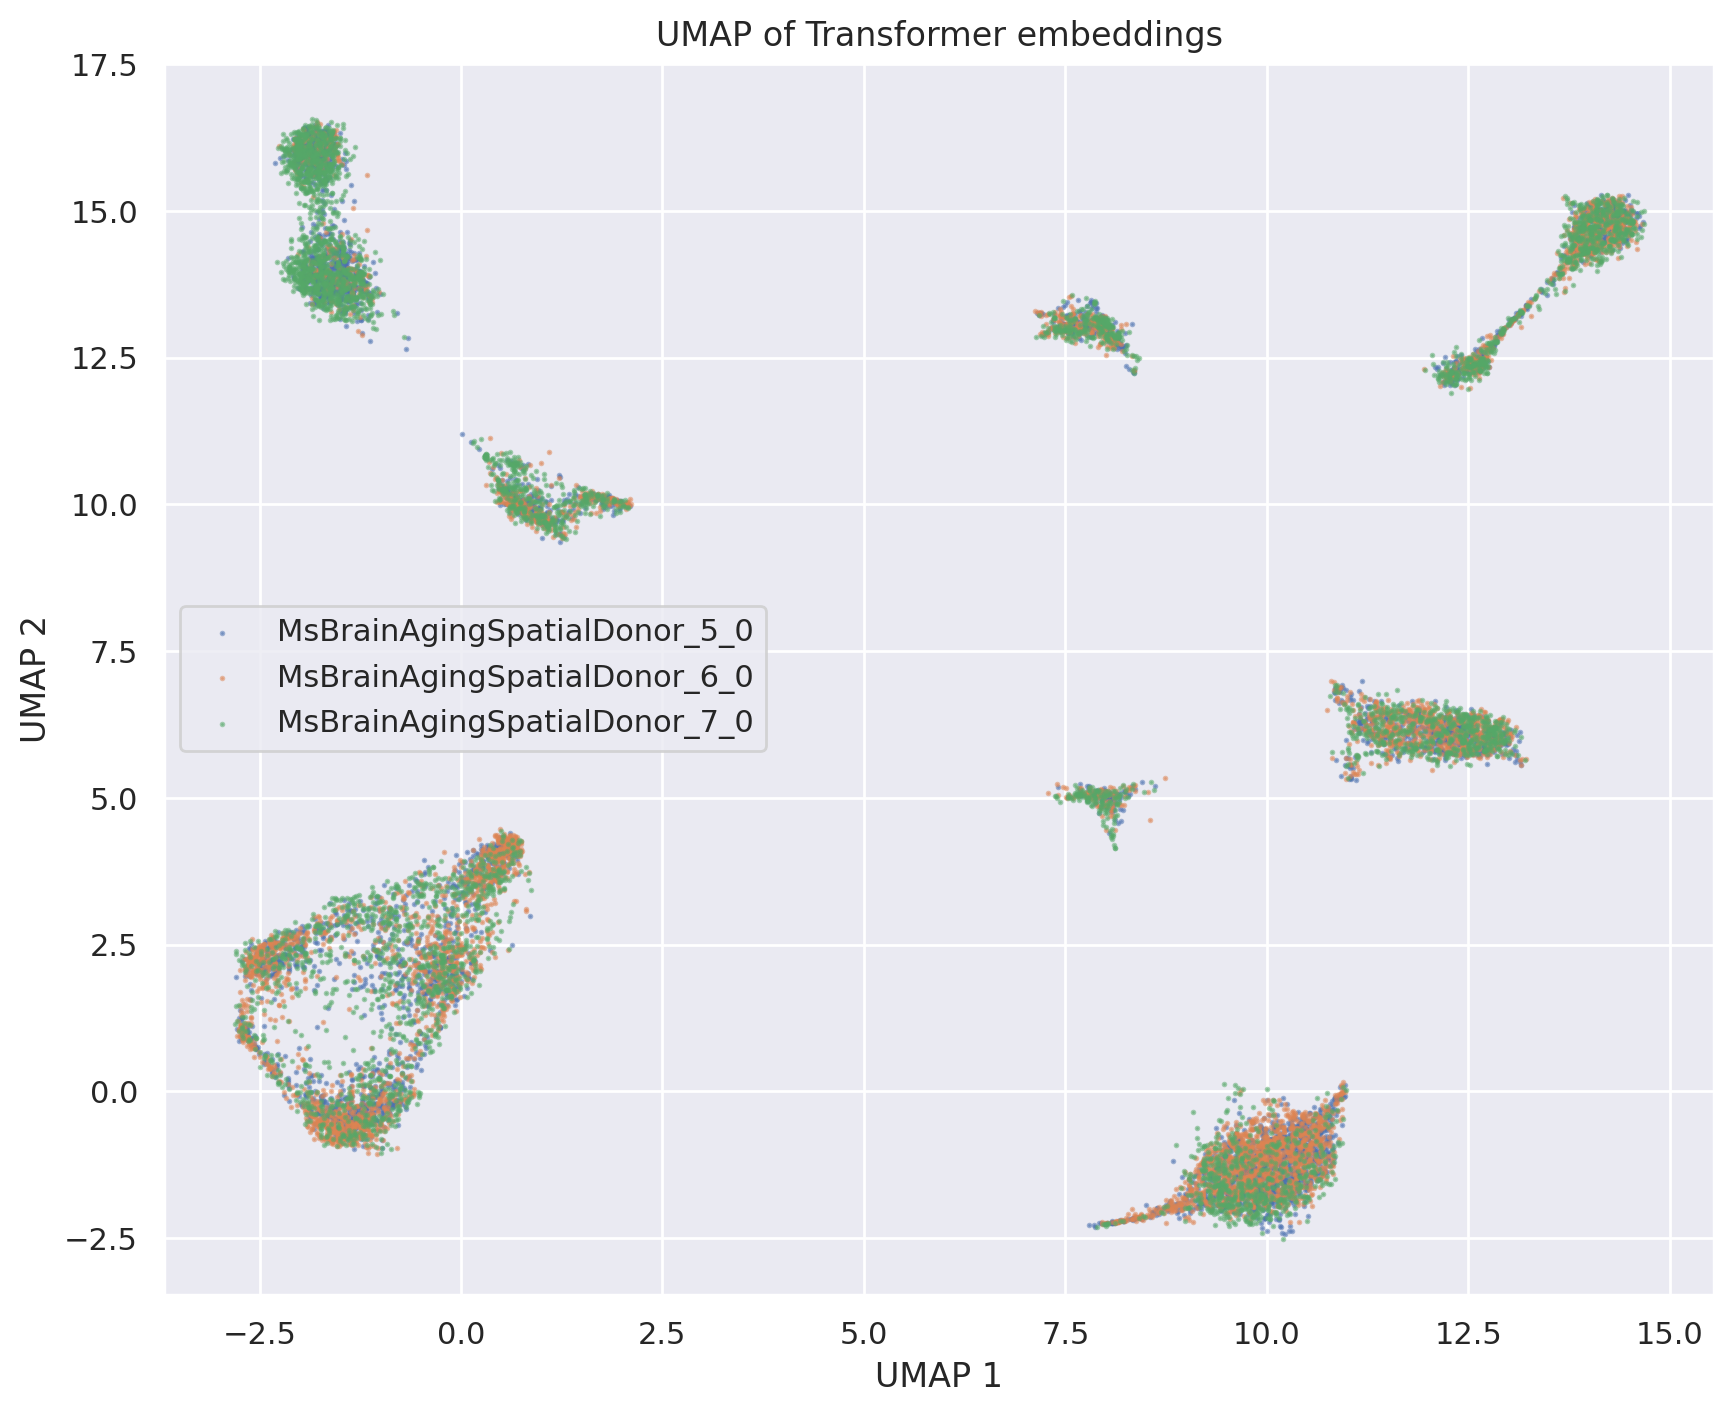

In [77]:
embeddingsTrf = []
for Xs in train_Xs:
    embeddingsTrf.append(model.getCellEmbedding(Xs[None, :, :])[0])
    
embeddingsTrfCat = np.concatenate(embeddingsTrf, axis=0)
numCells = [Xs.shape[0] for Xs in train_Xs]

from umap import UMAP

embeddingUmapTrf = UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42).fit_transform(embeddingsTrfCat)

plt.figure(figsize=(10, 8))
cnt = 0
for i, numCell in enumerate(numCells):
    plt.scatter(embeddingUmapTrf[cnt:cnt + numCell, 0], embeddingUmapTrf[cnt:cnt + numCell, 1], label=chosen_slices[i], s=1, alpha=0.5)
    cnt += numCell
plt.legend()
plt.title('UMAP of Transformer embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [80]:
adataTrain = adata[adata.obs['donor_slice'].isin(chosen_slices), :]
adataTrain.obs['donor_slice']

/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


59698927139295812388362741003745788589     MsBrainAgingSpatialDonor_5_0
135286066239277822083099936449845537191    MsBrainAgingSpatialDonor_5_0
36230115600570954051386082817058679406     MsBrainAgingSpatialDonor_5_0
272700543442277102036408593339718252224    MsBrainAgingSpatialDonor_5_0
217538183781914655709760009157548792709    MsBrainAgingSpatialDonor_5_0
                                                       ...             
125382427981999537759967071592698829967    MsBrainAgingSpatialDonor_7_0
155832986581483488064324437540534635925    MsBrainAgingSpatialDonor_7_0
334492001200555147743356206055789995001    MsBrainAgingSpatialDonor_7_0
10675129708281426744450783644033766312     MsBrainAgingSpatialDonor_7_0
336331504784704328393588895247069464714    MsBrainAgingSpatialDonor_7_0
Name: donor_slice, Length: 15000, dtype: category
Categories (3, object): ['MsBrainAgingSpatialDonor_5_0', 'MsBrainAgingSpatialDonor_6_0', 'MsBrainAgingSpatialDonor_7_0']

In [84]:
adataTrain.obs['umap1FF'] = embeddingUmapFF[:, 0]
adataTrain.obs['umap2FF'] = embeddingUmapFF[:, 1]

adataTrain.obs['umap1Trf'] = embeddingUmapTrf[:, 0]
adataTrain.obs['umap2Trf'] = embeddingUmapTrf[:, 1]

In [91]:
adataTrain.obs_keys()

['fov',
 'center_x',
 'center_y',
 'min_x',
 'max_x',
 'min_y',
 'max_y',
 'age',
 'clust_annot',
 'slice',
 'organism_ontology_term_id',
 'sex_ontology_term_id',
 'suspension_type',
 'cell_type_ontology_term_id',
 'assay_ontology_term_id',
 'tissue_ontology_term_id',
 'disease_ontology_term_id',
 'self_reported_ethnicity_ontology_term_id',
 'development_stage_ontology_term_id',
 'donor_id',
 'is_primary_data',
 'cell_type_annot',
 'cell_type',
 'assay',
 'disease',
 'organism',
 'sex',
 'tissue',
 'self_reported_ethnicity',
 'development_stage',
 'donor_slice',
 'umap1FF',
 'umap2FF',
 'umap1Trf',
 'umap2Trf']

/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):


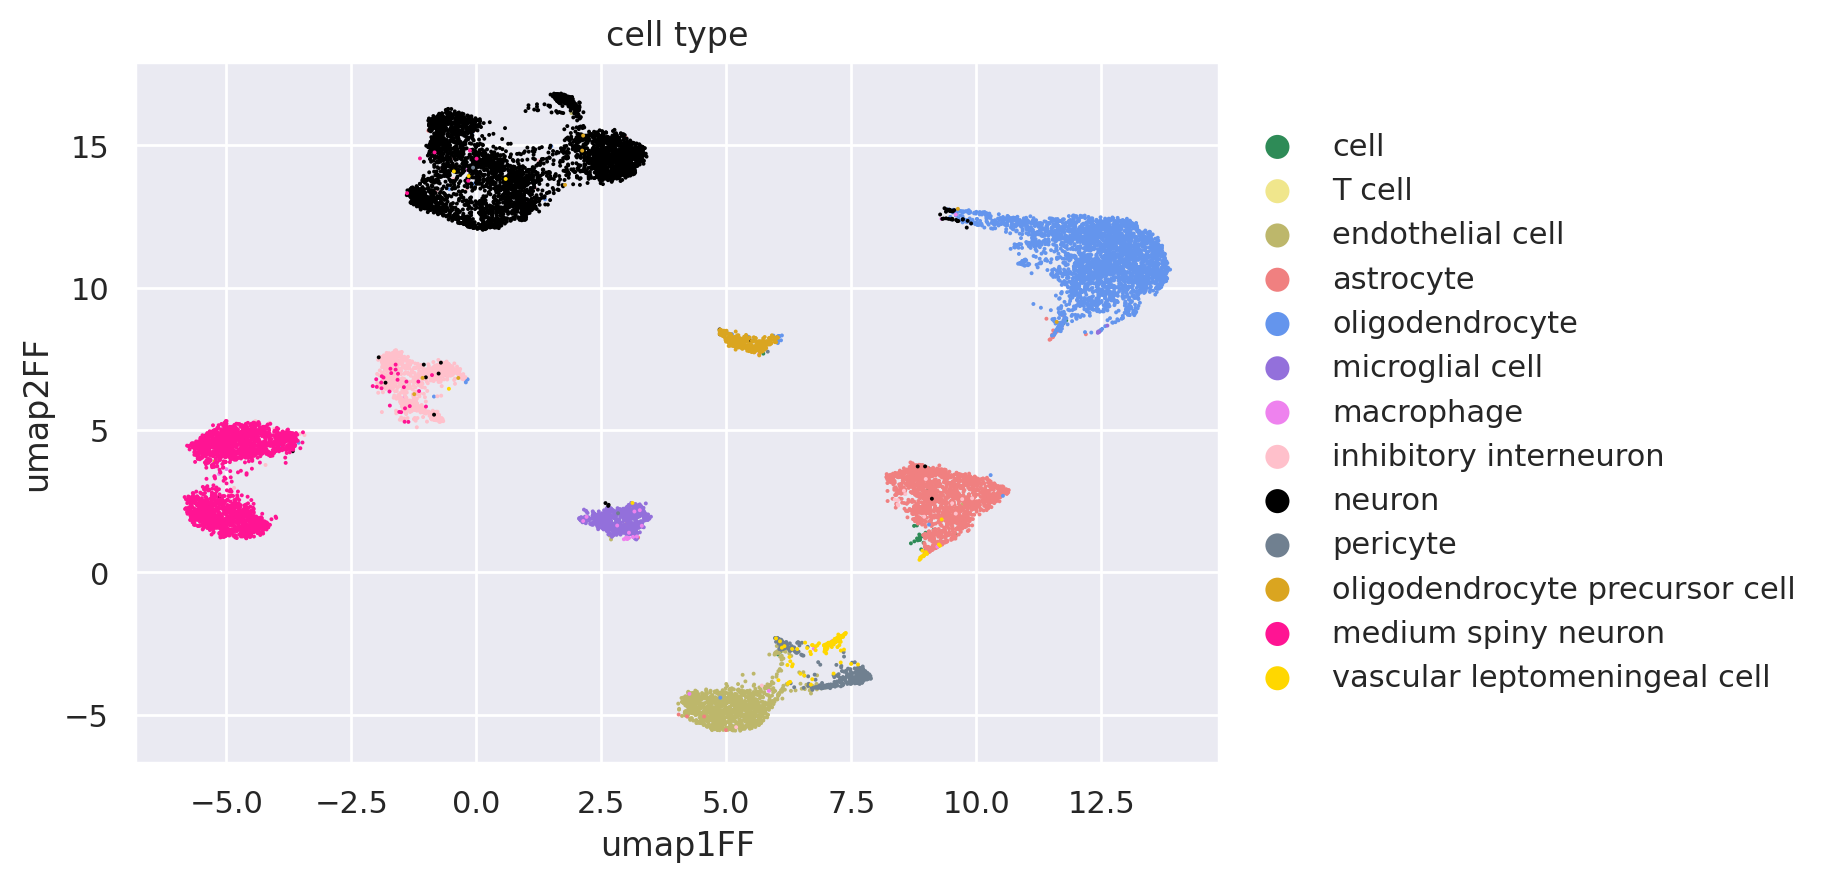

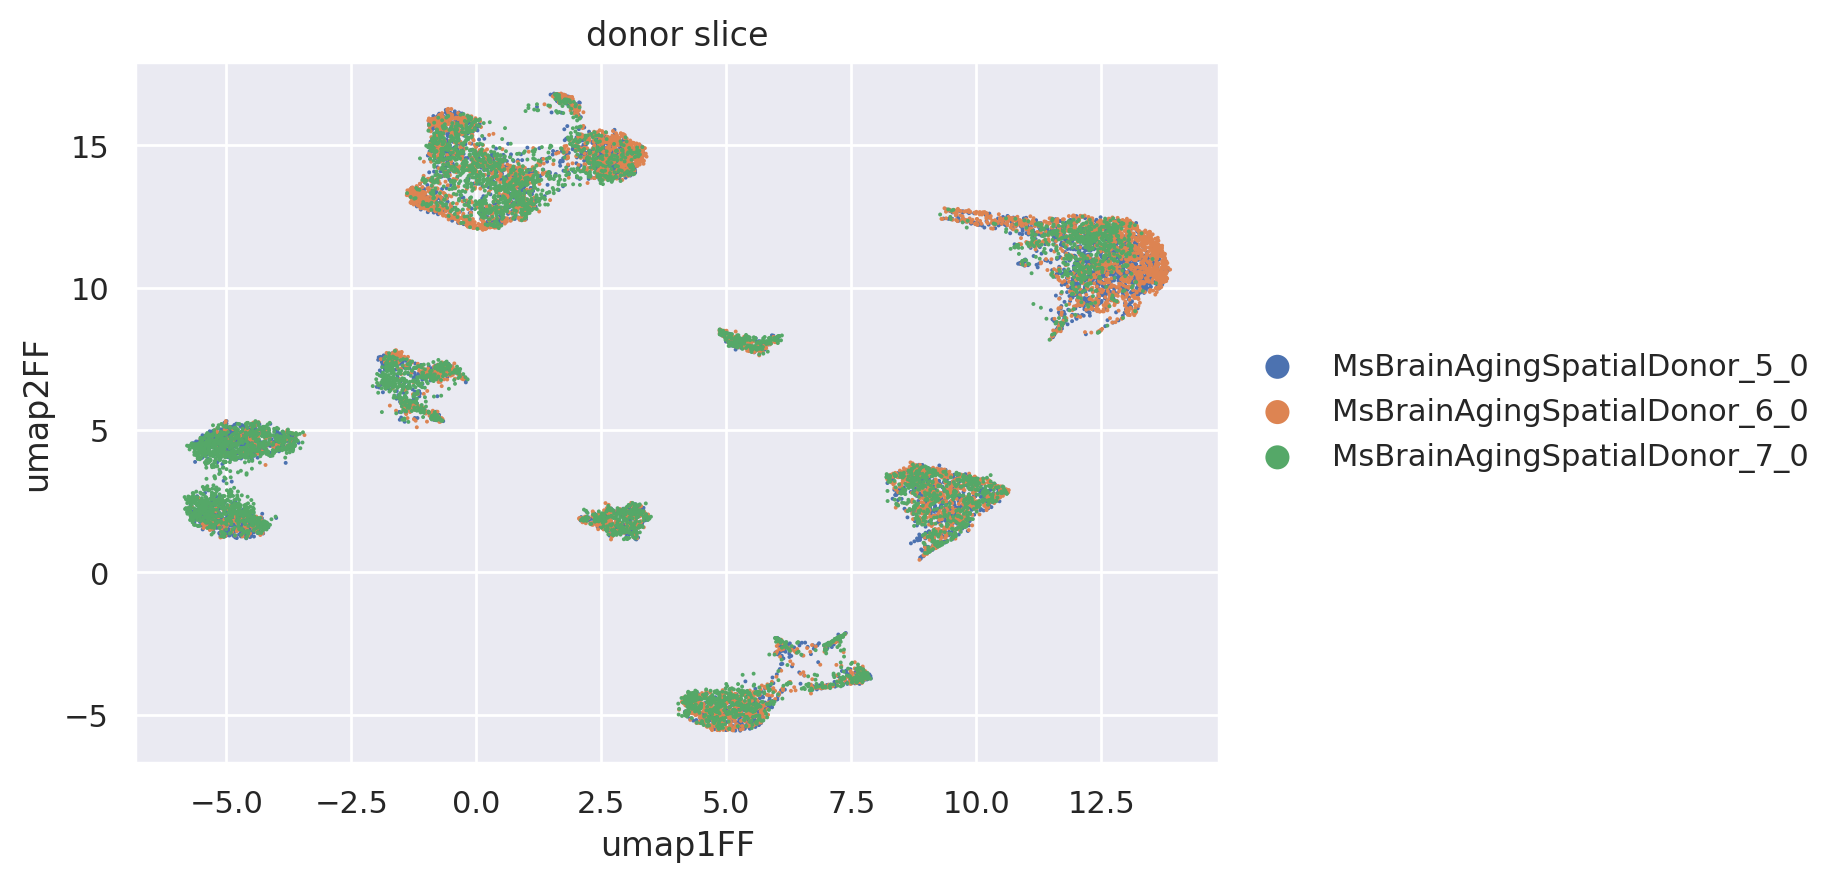

In [96]:
sc.pl.scatter(adataTrain, color='cell_type', x='umap1FF', y='umap2FF')
sc.pl.scatter(adataTrain, color='donor_slice', x='umap1FF', y='umap2FF')


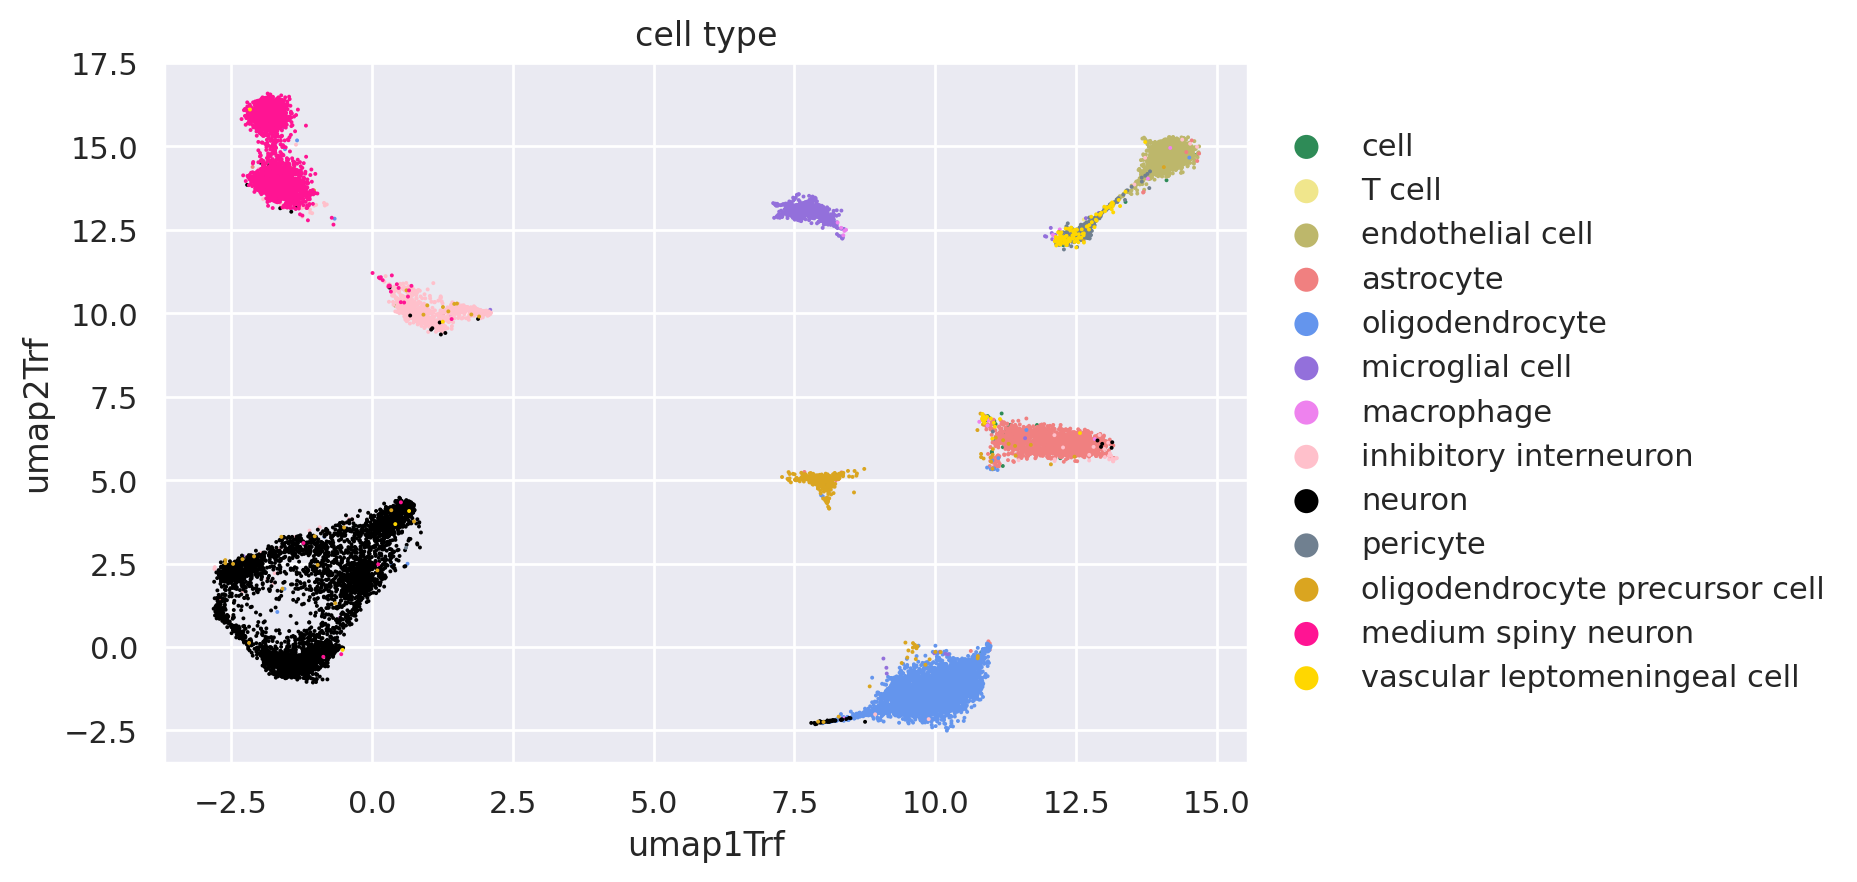

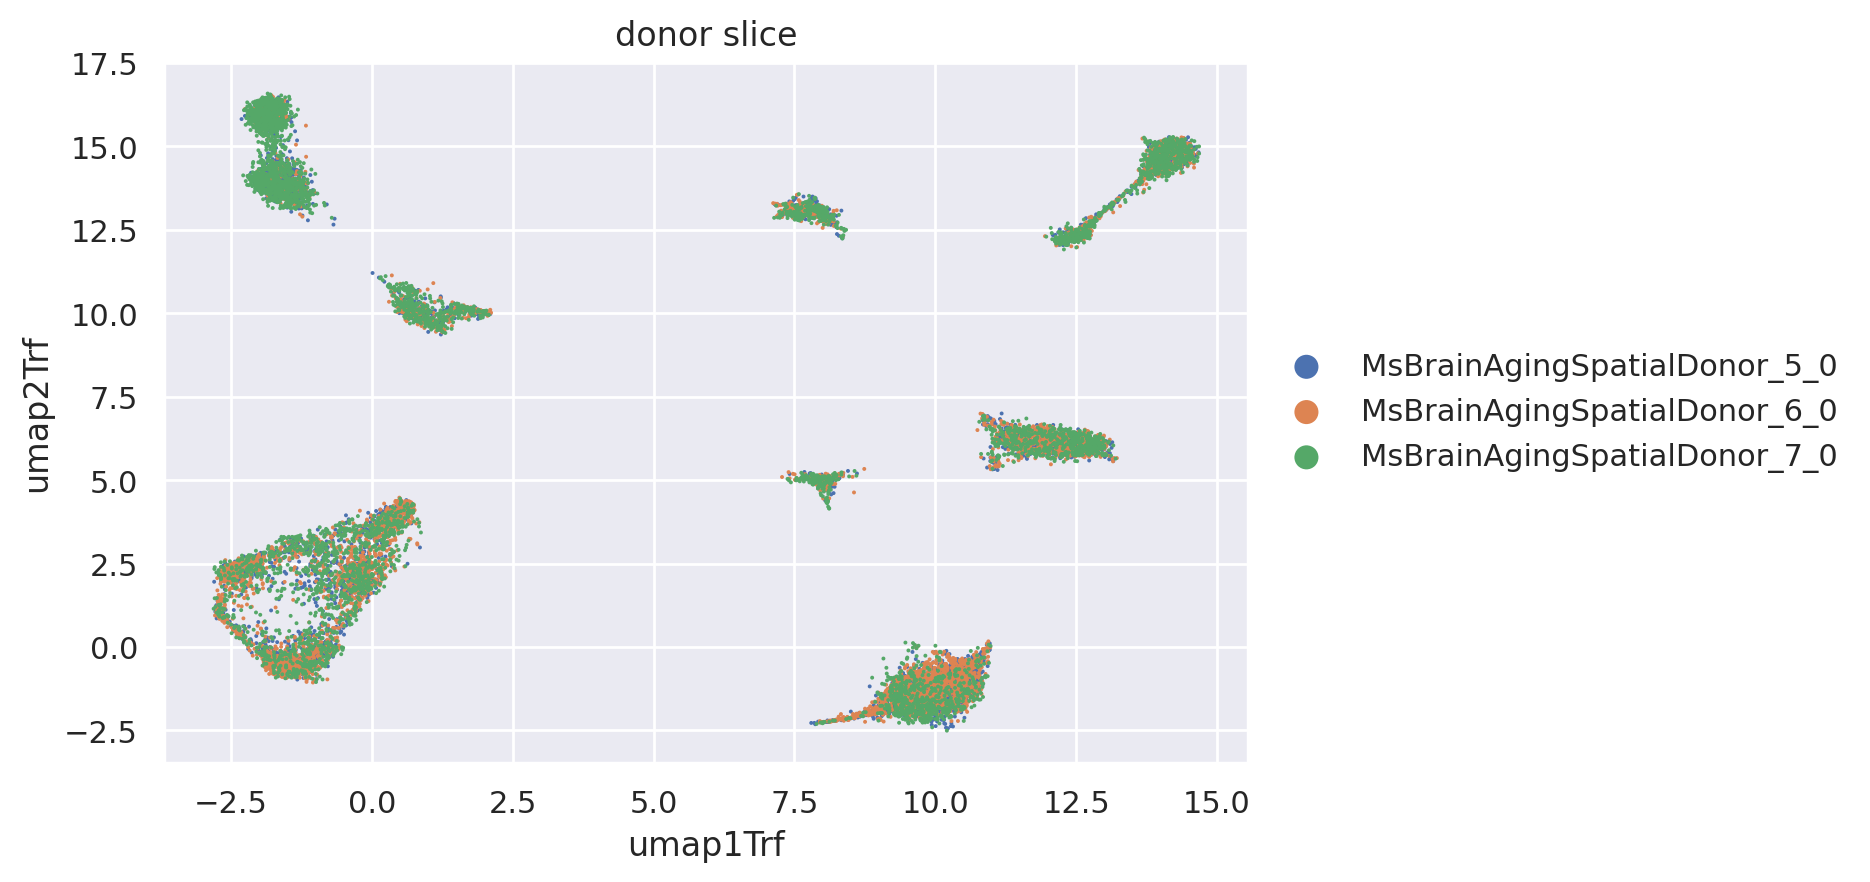

In [97]:
sc.pl.scatter(adataTrain, color='cell_type', x='umap1Trf', y='umap2Trf')
sc.pl.scatter(adataTrain, color='donor_slice', x='umap1Trf', y='umap2Trf')